# **Import Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Import Library**

In [ ]:
!pip install optuna
!pip install catboost
!pip install scikeras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 15.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 2.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np
from tqdm.notebook import tqdm
import re
from functools import partial
from scipy.stats import mode
import matplotlib.pyplot as plt; plt.style.use('ggplot')
import seaborn as sns
import plotly.express as px
from sklearn.linear_model import Lasso, LinearRegression, Ridge, ElasticNet
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder, FunctionTransformer, PowerTransformer, PolynomialFeatures, RobustScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, SimpleImputer, IterativeImputer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RepeatedStratifiedKFold, cross_val_score, cross_val_predict, RepeatedKFold
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, cohen_kappa_score, log_loss, f1_score, median_absolute_error, accuracy_score, mean_squared_error
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.feature_selection import RFE, RFECV
from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import CalibrationDisplay
from sklearn.inspection import PartialDependenceDisplay, permutation_importance
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, GradientBoostingRegressor, ExtraTreesRegressor, VotingRegressor, StackingRegressor, BaggingRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping, TerminateOnNaN
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam, SGD, Nadam, Adagrad, Adadelta, RMSprop
import tensorflow_probability as tfpw
from scikeras.wrappers import KerasRegressor
import optuna
import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp
import warnings
warnings.filterwarnings('ignore')
sns.set()
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.base import BaseEstimator, RegressorMixin, TransformerMixin,clone
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score

# **Import Data**

In [ ]:
airqual_train = {
    i: pd.read_csv(f'airqual_loc0{i}_train.csv', index_col='available_at', parse_dates=True) if i < 10
    else pd.read_csv(f'airqual_loc{i}_train.csv', index_col='available_at', parse_dates=True)
    for i in range(1, 11)
}

weather_train = {
    i: pd.read_csv(f'weather_loc0{i}_train.csv', index_col='available_at', parse_dates=True)
        .iloc[79:] if i < 10 else
       pd.read_csv(f'weather_loc{i}_train.csv', index_col='available_at', parse_dates=True).iloc[79:]
    for i in range(1, 11)
}


airqual_test = {
    i: pd.read_csv(f'airqual_loc0{i}_test.csv', index_col='available_at', parse_dates=True) if i < 10
    else pd.read_csv(f'airqual_loc{i}_test.csv', index_col='available_at', parse_dates=True)
    for i in range(1, 11)
}

weather_test = {
    i: pd.read_csv(f'weather_loc0{i}_test.csv', index_col='available_at', parse_dates=True) if i < 10
    else pd.read_csv(f'weather_loc{i}_test.csv', index_col='available_at', parse_dates=True)
    for i in range(1, 11)
}

label = pd.read_csv("label.csv")
location = pd.read_csv("location.csv")

# **Exploratory Data Analysis (EDA) Pertama** 📊

Di EDA pertama ini, saya berfokus untuk mengeksplor nilai-nilai yang perlu dicleaning dan preprocessing.

**Location**

In [ ]:
location.head(10)

,filename,latitude,longitude
0,loc_1,-6.667068,106.695917
1,loc_2,-6.194980,106.820495
2,loc_3,-6.392120,105.828500
3,loc_4,-5.428496,105.188337
4,loc_5,-6.309700,106.106500
5,loc_6,-7.024200,106.546400
6,loc_7,-5.585748,105.384948
7,loc_8,-6.013420,106.094512
8,loc_9,-6.781000,106.997922
9,loc_10,-5.892740,106.030800


Berdasarkan kolom longitude dan latitude pada data location, saya mencari alamat asli dari lokasi tersebut. Hal tersebut dilakukan dengan tujuan untuk mencari lokasi dengan kepadatan penduduk tertinggi dan memiliki aktivitas penduduk yang tinggi juga.

1. Loc01
Jl. Kp. Rw. Desa, Gn. Bunder 2, Kec. Pamijahan, Kabupaten Bogor, Jawa Barat 16810

2.  Loc02
Jakarta Pusat, Kb. Melati, Kecamatan Tanah Abang, Kota Jakarta Pusat, Daerah Khusus Ibukota Jakarta 10230 -> Mall

3. Loc03
Jl. Kepenimbangan No.24, Margasana, Kec. Pagelaran, Kabupaten Pandeglang, Banten 42265

4. Loc04
Hutan, Kec. Hutan, Kabupaten Pesawaran, Lampung

5. loc05
Alun pandeglang, Pandeglang, Pandeglang Sub-District, Pandeglang Regency, Banten

6. loc06
Citarik, Kec. Pelabuhanratu, Kabupaten Sukabumi, Jawa Barat

7. loc07
Karya Tunggal, Kec. Katibung, Kabupaten Lampung Selatan, Lampung

8. loc08
Terate, Kec. Kramatwatu, Kabupaten Serang, Banten

9. loc09
Ciputri, Kec. Pacet, Kabupaten Cianjur, Jawa Barat

10. loc10
Jl. Suralaya, Suralaya, Kec. Pulomerak, Kota Cilegon, Banten 42439

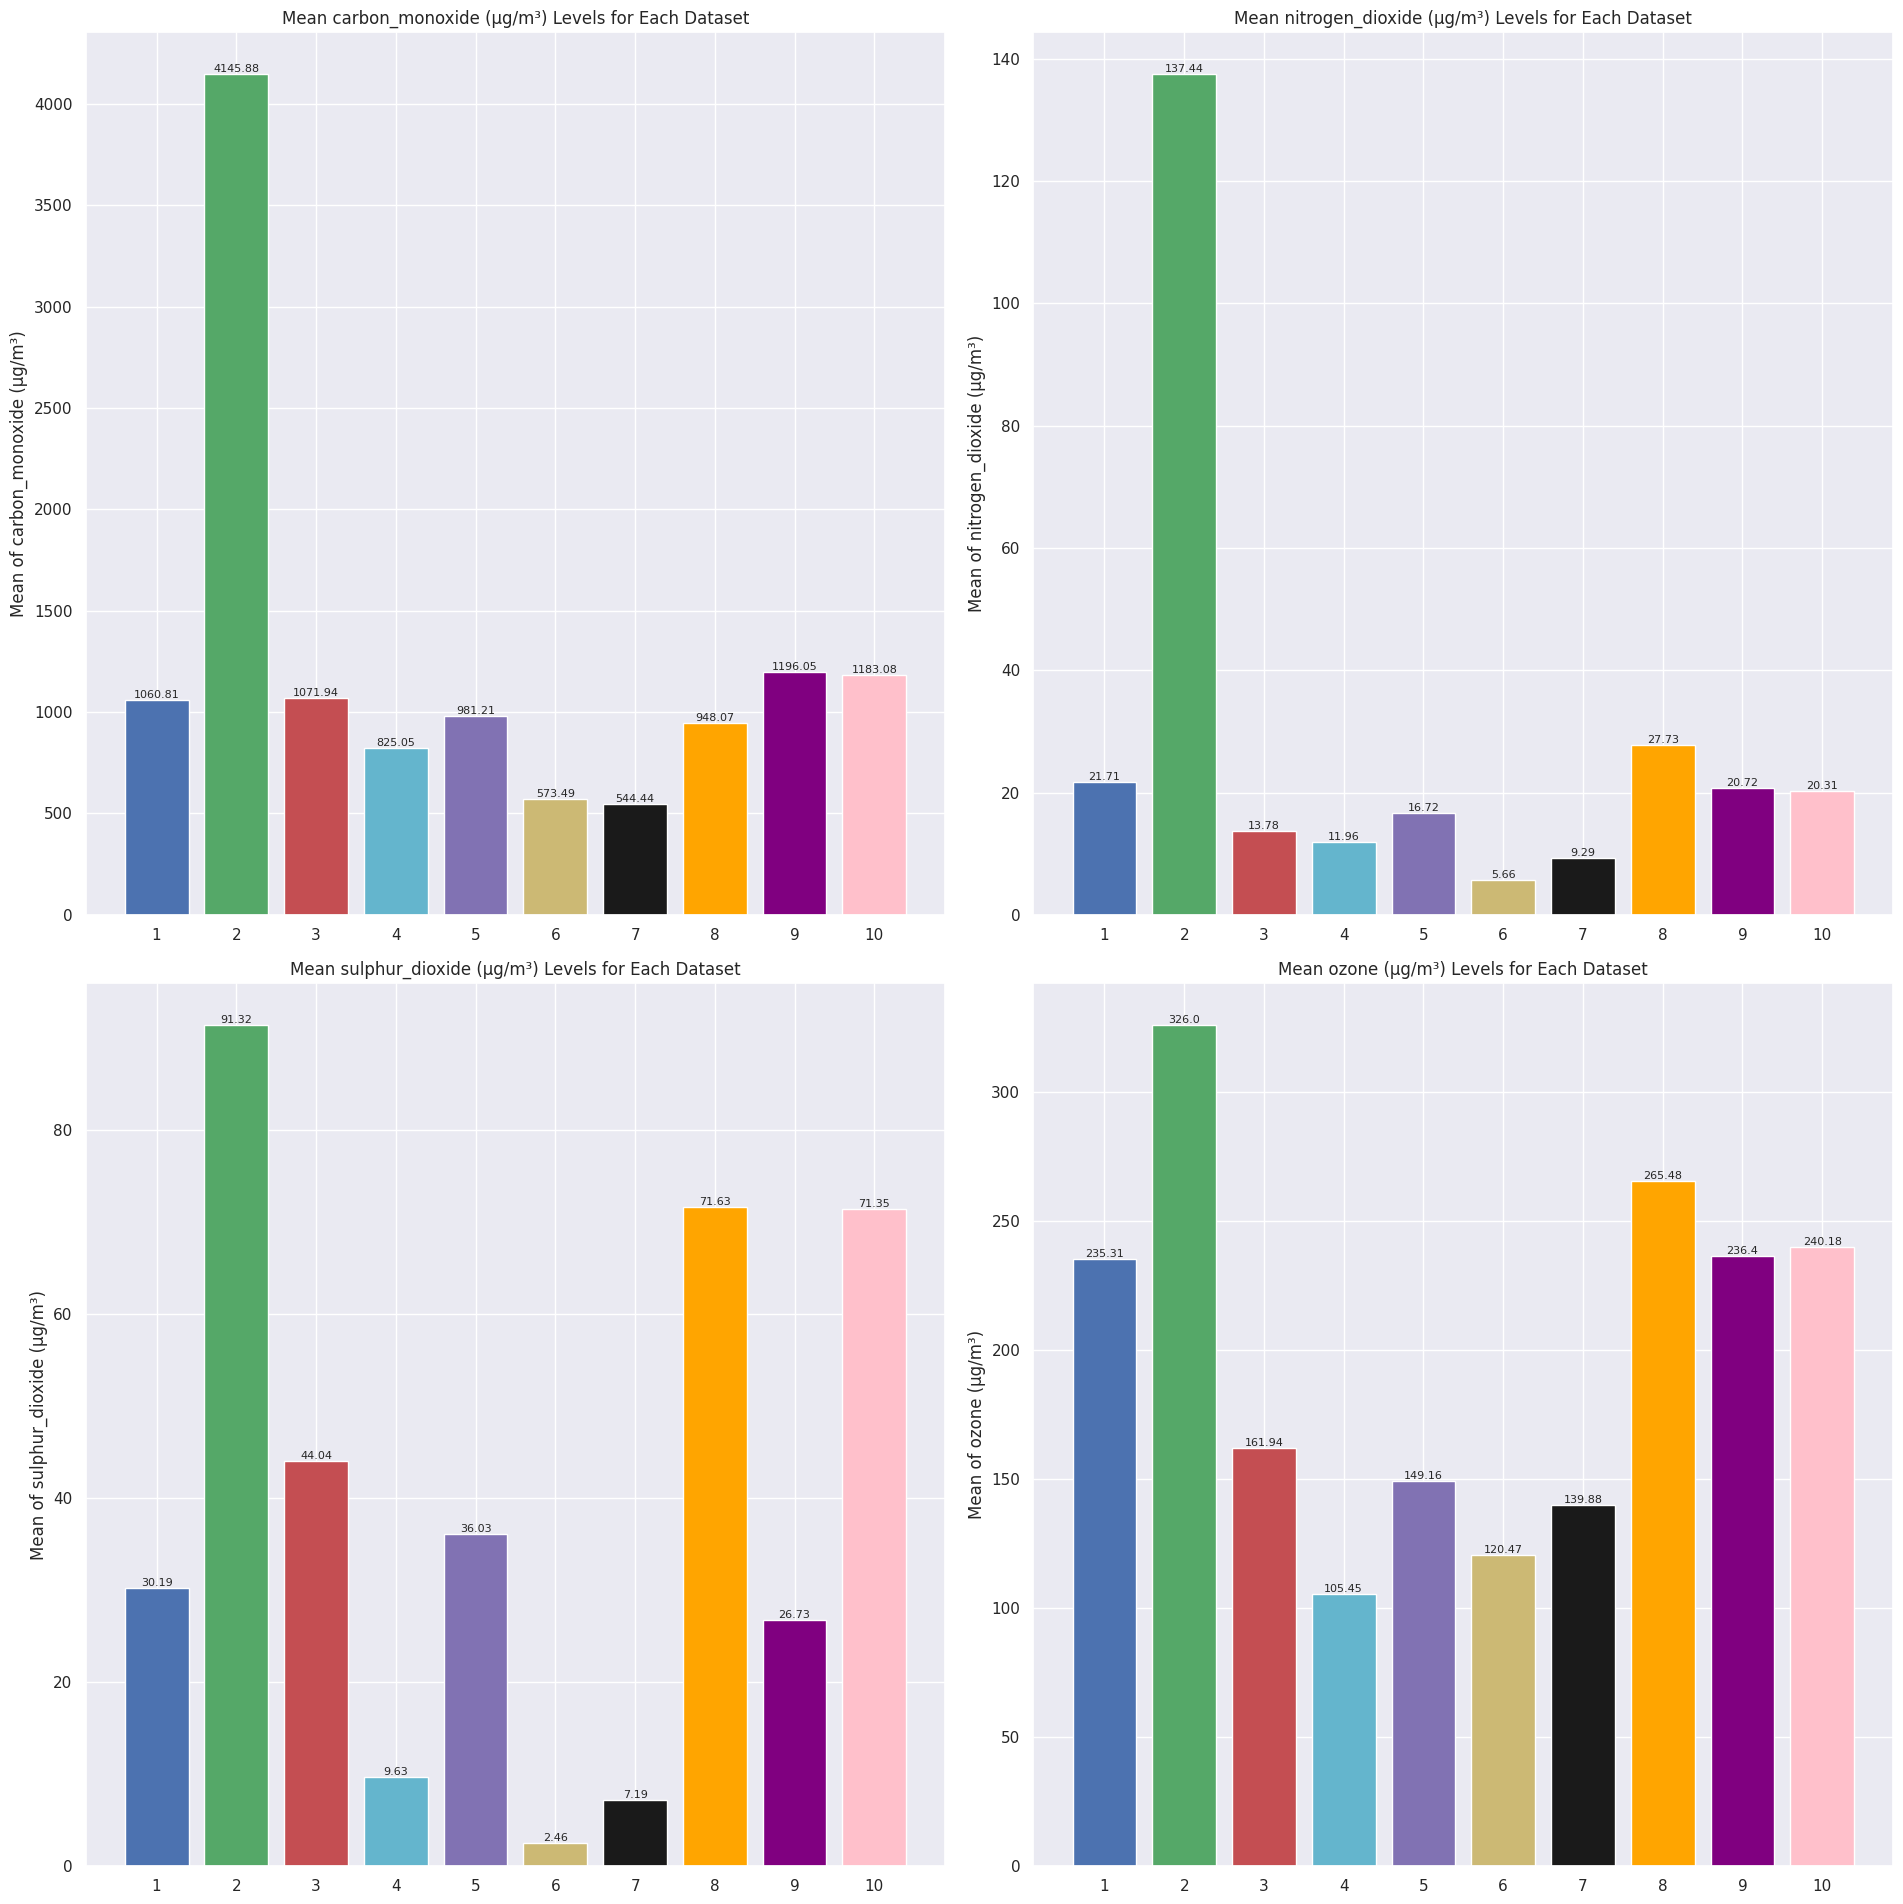

In [ ]:
for h,i in enumerate(['carbon_monoxide (μg/m³)','nitrogen_dioxide (μg/m³)','sulphur_dioxide (μg/m³)','ozone (μg/m³)']):
    plt.subplot(2,2,h+1)
    means = [df[i].mean() for j, df in airqual_test.items()]
    x = np.arange(len(means))
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange', 'purple', 'pink']
    bars = plt.bar(x, means, color=colors)
    plt.xticks(x, [str(i+1) for i in range(len(means))])
    plt.ylabel(f'Mean of {i}')
    plt.title(f'Mean {i} Levels for Each Dataset')
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom', fontsize=8)

plt.tight_layout(rect=[0, 0, 3, 4])
plt.show()

Setelah membuat grafik untuk komponen-komponen yang menyebabkan polusi, dapat diketahui bahwa loc2 atau suatu daerah yang berada pada kota jakarta adalah daerah dengan polutan tertinggi diantara 9 daerah lainnya. Dengan grafik dan juga data yang beredar di internet, bisa diasumsikan bahwa kepadatan penduduk di Jakarta menjadi penyebab tingginya nilai polutan di lokasi tersebut. Oleh karena itu, untuk EDA pertama, saya mengutamakan untuk mengamati data dari lokasi ke-2.

**Airqual Train**

In [ ]:
airqual_train[2].head()

,carbon_monoxide (μg/m³),nitrogen_dioxide (μg/m³),sulphur_dioxide (μg/m³),ozone (μg/m³),dust (μg/m³),uv_index (),uv_index_clear_sky ()
available_at,,,,,,,
2022-08-04 11:00:00,3182.0,94.9,50.6,51.0,0.0,0.3,0.3
2022-08-04 12:00:00,3090.0,91.7,56.6,99.0,0.0,1.2,1.4
2022-08-04 13:00:00,2955.0,86.9,65.1,167.0,0.0,3.0,199.9
2022-08-04 14:00:00,2690.0,75.8,70.5,NaN,0.0,4.6,5.2
2022-08-04 15:00:00,2379.0,59.5,65.2,303.0,0.0,5.2,6.4


Berdasarkan data, dapat dilihat bahwa carbon monoxide merupakan partikel yang paling memberikan dampak terhadap angka dari PM10 itu sendiri. Selain itu, terdapat nan values pada data, yang nantinya akan diberikan perhatian khusus untuk penanganannya. Namun, terdapat keunikan pada salah satu fitur, yaitu dust karena nilai dari kolom tersebut didominasi oleh angka null

In [ ]:
airqual_train[2].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10141 entries, 2022-08-04 11:00:00 to 2023-09-30 23:00:00
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   carbon_monoxide (μg/m³)   9650 non-null   float64
 1   nitrogen_dioxide (μg/m³)  9829 non-null   float64
 2   sulphur_dioxide (μg/m³)   9696 non-null   float64
 3   ozone (μg/m³)             9650 non-null   float64
 4   dust (μg/m³)              9903 non-null   float64
 5   uv_index ()               9830 non-null   float64
 6   uv_index_clear_sky ()     9730 non-null   float64
dtypes: float64(7)
memory usage: 633.8 KB


In [ ]:
airqual_train[2].describe()

,carbon_monoxide (μg/m³),nitrogen_dioxide (μg/m³),sulphur_dioxide (μg/m³),ozone (μg/m³),dust (μg/m³),uv_index (),uv_index_clear_sky ()
count,9.650000e+03,9829.000000,9696.000000,9650.000000,9903.000000,9830.000000,9730.00000
mean,5.873369e+03,182.696968,65.122092,291.539285,0.089841,4.663377,7.80334
std,3.126308e+04,1002.804083,326.702756,1621.597081,2.382651,41.714345,62.68740
min,-1.090131e+05,-5999.000000,-2830.500000,-23000.300000,0.000000,-193.600000,-152.80000
25%,1.006000e+03,37.900000,18.900000,29.000000,0.000000,0.000000,0.00000
50%,1.714000e+03,62.400000,29.400000,53.000000,0.000000,0.000000,0.00000
75%,2.843000e+03,101.100000,41.525000,138.000000,0.000000,2.900000,4.00000
max,1.000618e+06,26229.400000,9163.000000,34609.200000,131.300000,1229.500000,1977.10000


Dengan menggunakan method describe saya bisa mendeteksi bahwa pada data airqual terdapat outlier. Seperti contoh, rata-rata dari nilai kolom carbon monoksida adalah 5800an sedangkan maximum valuenya ada di sekitar 100.000an. Berdasarkan informasi tersebut, saya membuat pertimbangan untuk menangani outlier atau hanya membiarkannya saja.

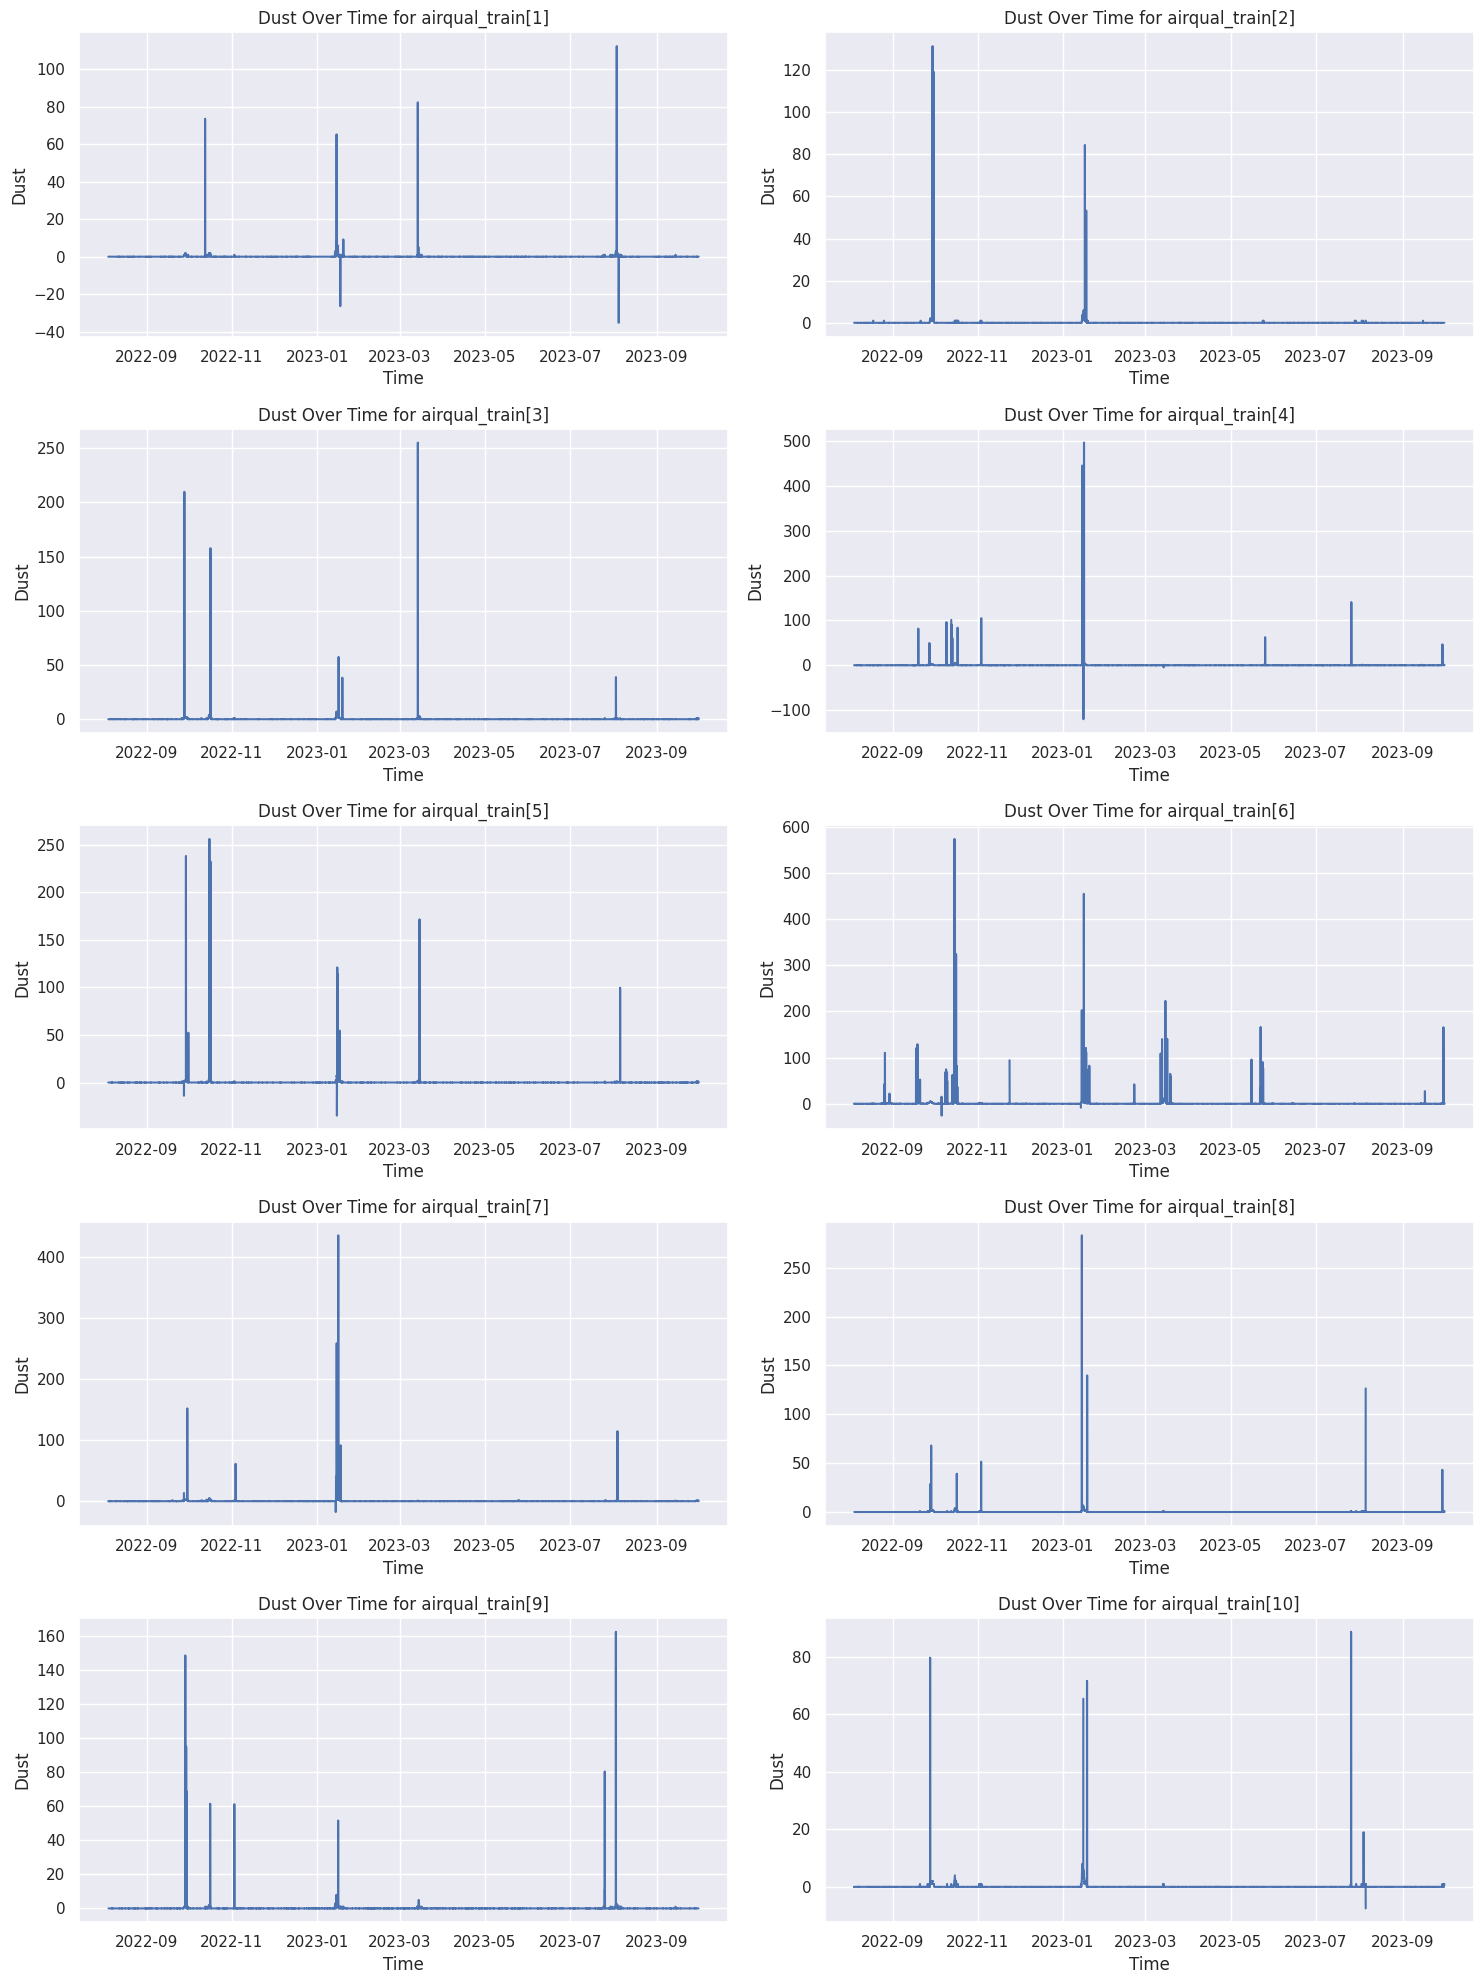

In [ ]:
fig, axs = plt.subplots(5, 2, figsize=(15, 20))
axs = axs.ravel()

for i in range(1, 11):
    axs[i-1].plot(airqual_train[i]['dust (μg/m³)'])
    axs[i-1].set_title(f'Dust Over Time for airqual_train[{i}]')
    axs[i-1].set_xlabel('Time')
    axs[i-1].set_ylabel('Dust')

plt.tight_layout()
plt.show()

Fitur dust memiliki suatu keunikan yaitu nilai dari datanya yang mayoritas dipenuhi oleh angka null. Sehingga nantinya saya akan melakukan 2 percobaan, yaitu dengan drop fitur dust dan membuat fitur baru dengan memanfaatkan fitur dust.

**Weather Train**

In [ ]:
weather_train[2].head()

,temperature_2m (°C),relative_humidity_2m (%),dew_point_2m (°C),apparent_temperature (°C),rain (mm),pressure_msl (hPa),surface_pressure (hPa),cloud_cover (%),cloud_cover_low (%),cloud_cover_mid (%),cloud_cover_high (%),wind_speed_10m (km/h),wind_speed_100m (km/h),wind_direction_10m (°),wind_direction_100m (°),wind_gusts_10m (km/h)
available_at,,,,,,,,,,,,,,,,
2022-08-04 11:00:00,23.9,96.0,23.1,4914.0,0.0,1010.3,1009.4,31.0,0.0,2.0,100.0,5.0,5.6,159.0,130.0,7.9
2022-08-04 12:00:00,26.0,84.0,23.1,31.2,0.0,1011.2,1010.3,32.0,1.0,3.0,99.0,2.5,4.4,98.0,99.0,11.5
2022-08-04 13:00:00,27.7,76.0,23.0,32.9,0.0,1011.4,1010.5,31.0,0.0,2.0,100.0,2.5,3.6,NaN,53.0,11.9
2022-08-04 14:00:00,29.2,70.0,23.1,34.8,0.0,1011.4,1010.5,903.0,NaN,3.0,100.0,3.1,3.9,21.0,22.0,17.6
2022-08-04 15:00:00,30.1,66.0,23.2,36.4,0.0,1010.7,1009.8,34.0,3.0,3.0,100.0,3.8,4.5,17.0,14.0,18.7


In [ ]:
weather_train[2].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10141 entries, 2022-08-04 11:00:00 to 2023-09-30 23:00:00
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   temperature_2m (°C)        9676 non-null   float64
 1   relative_humidity_2m (%)   9834 non-null   float64
 2   dew_point_2m (°C)          9663 non-null   float64
 3   apparent_temperature (°C)  9900 non-null   float64
 4   rain (mm)                  9709 non-null   float64
 5   pressure_msl (hPa)         9674 non-null   float64
 6   surface_pressure (hPa)     9885 non-null   float64
 7   cloud_cover (%)            9669 non-null   float64
 8   cloud_cover_low (%)        9836 non-null   float64
 9   cloud_cover_mid (%)        9909 non-null   float64
 10  cloud_cover_high (%)       9879 non-null   float64
 11  wind_speed_10m (km/h)      9825 non-null   float64
 12  wind_speed_100m (km/h)     9897 non-null   float64
 13  wind_direct

In [ ]:
weather_train[2].describe()

,temperature_2m (°C),relative_humidity_2m (%),dew_point_2m (°C),apparent_temperature (°C),rain (mm),pressure_msl (hPa),surface_pressure (hPa),cloud_cover (%),cloud_cover_low (%),cloud_cover_mid (%),cloud_cover_high (%),wind_speed_10m (km/h),wind_speed_100m (km/h),wind_direction_10m (°),wind_direction_100m (°),wind_gusts_10m (km/h)
count,9676.000000,9834.000000,9663.000000,9900.000000,9709.000000,9674.000000,9885.000000,9669.000000,9836.000000,9909.000000,9879.000000,9825.000000,9897.000000,9768.000000,9820.000000,9878.00000
mean,96.934963,238.303793,73.449312,100.877000,1.133845,2707.056295,3718.169246,168.860058,46.265840,67.088384,228.029446,22.670758,34.157674,710.312879,600.082770,55.05083
std,399.591296,1030.482137,305.510184,417.232745,26.159828,11867.067726,14949.309338,816.998852,378.652113,423.476258,1082.116008,109.644857,163.016596,3117.202363,2776.479406,267.36001
min,-1241.400000,-4371.500000,-1280.300000,-1441.400000,-132.000000,-56524.400000,-52599.900000,-4038.800000,-631.000000,-2183.300000,-5630.900000,-876.800000,-834.400000,-9463.000000,-18145.900000,-1628.50000
25%,24.400000,71.000000,22.300000,29.000000,0.000000,1008.600000,1007.800000,30.000000,0.000000,3.000000,51.000000,3.900000,6.400000,133.000000,118.000000,9.40000
50%,26.200000,85.000000,23.000000,31.000000,0.000000,1010.000000,1009.200000,41.000000,5.000000,13.000000,99.000000,5.800000,10.100000,205.000000,210.000000,14.80000
75%,29.425000,93.000000,23.700000,33.900000,0.100000,1011.400000,1010.600000,66.000000,17.000000,32.000000,100.000000,9.200000,15.400000,263.000000,263.000000,22.70000
max,5108.700000,13916.400000,4167.100000,5305.700000,1913.800000,183683.700000,162742.500000,16355.300000,11515.600000,11730.200000,15727.000000,2070.100000,2713.600000,62583.200000,48879.000000,5974.00000


Berdasarkan method describe, dapat dilihat bahwa data weather memiliki sejumlah outlier. Seperti contoh, pada kolom temperature, rata-rata dari suhu adalah 96an tetapi nilai minimum dan maximum bernilai jauh dari rata-rata, yaitu -1241.4 dan 5108.7. Oleh karena itu, saya juga akan melakukan percobaan untuk menghandle outlier dan juga membiarkannya saja.

**Correlation between Rain and PM10**

Berdasarkan hasil research dan asumsi pribadi, hujan dapat menurunkan tingkat PM10 pada udara.
Hujan dapat membantu mengencerkan polutan di udara dengan konsentrasi tinggi. Karena partikel PM10 seperti debu, kotoran, dan serbuk sari lebih besar dan lebih berat daripada partikel lainnya, hujan dapat membantu PM10 mengendap di tanah lebih cepat. Selain itu, hujan dapat membantu mengendapkan polutan yang terlihat, mengurangi konsentrasi polutan di udara yang tinggi. Dan juga, saat air hujan turun, air hujan juga dapat menarik polutan partikel yang diangin-anginkan dalam proses yang disebut koagulasi.

Oleh karena itu, data weather dapat membantu untuk mengenali pola hujan pada suatu daerah. Pola hujan itu akan berpengaruh pada performans model dalam membuat prediksi

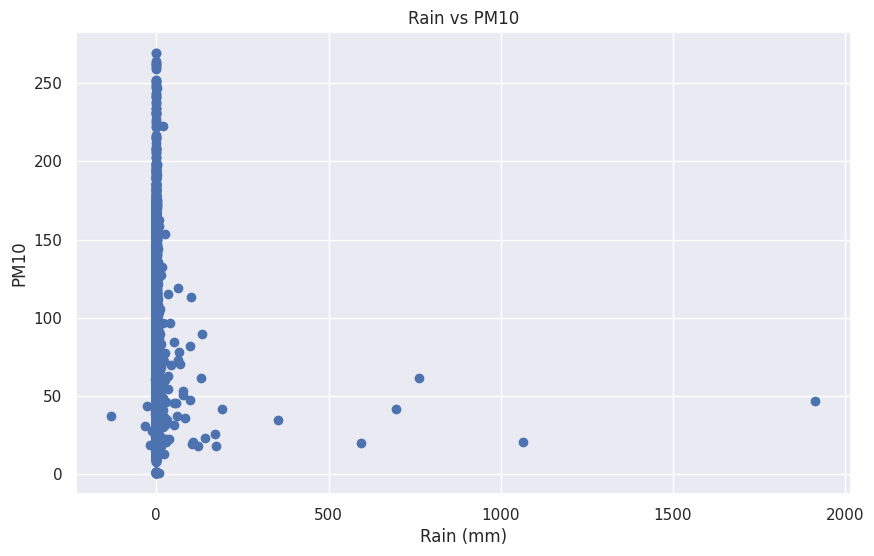

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(weather_train[2]['rain (mm)'], label['pm10 (μg/m³)'][10141:20282])
plt.title('Rain vs PM10')
plt.xlabel('Rain (mm)')
plt.ylabel('PM10')
plt.show()

**Check Null**

In [ ]:
def check_null(df):
    col_na = df.isnull().sum().sort_values(ascending=True)
    percent = col_na / len(df)
    missing_data = pd.concat([col_na, percent], axis=1, keys=['Total', 'Percent'])
    print(i)
    if (missing_data[missing_data['Total'] > 0].shape[0] == 0):
        print("Tidak ditemukan missing value pada dataset")
    else:
        print(missing_data[missing_data['Total'] > 0])
    print()
    return col_na.sum()

total_missing_values = 0
for i in range(1,11):
    total_missing_values += check_null(airqual_train[i])
    total_missing_values += check_null(weather_train[i])

print("Total missing values across all datasets: ", total_missing_values)

1
                          Total   Percent
dust (μg/m³)                236  0.023272
ozone (μg/m³)               300  0.029583
carbon_monoxide (μg/m³)     315  0.031062
sulphur_dioxide (μg/m³)     371  0.036584
nitrogen_dioxide (μg/m³)    404  0.039838
uv_index_clear_sky ()       424  0.041810
uv_index ()                 425  0.041909

1
                           Total   Percent
cloud_cover (%)              239  0.023568
wind_gusts_10m (km/h)        263  0.025934
apparent_temperature (°C)    279  0.027512
surface_pressure (hPa)       285  0.028104
wind_speed_100m (km/h)       289  0.028498
rain (mm)                    299  0.029484
dew_point_2m (°C)            327  0.032245
pressure_msl (hPa)           337  0.033231
cloud_cover_mid (%)          357  0.035204
wind_speed_10m (km/h)        405  0.039937
wind_direction_10m (°)       406  0.040035
cloud_cover_low (%)          422  0.041613
cloud_cover_high (%)         480  0.047333
temperature_2m (°C)          501  0.049403
wind_direction

Pada data airqual dan juga weather, terdapat 81887 nan values. Karena hal tersebut, saya akan melakukan 2 percobaan nantinya, yaitu dengan menggunakan Iterative Imputer atau KNN Imputer

**Label**

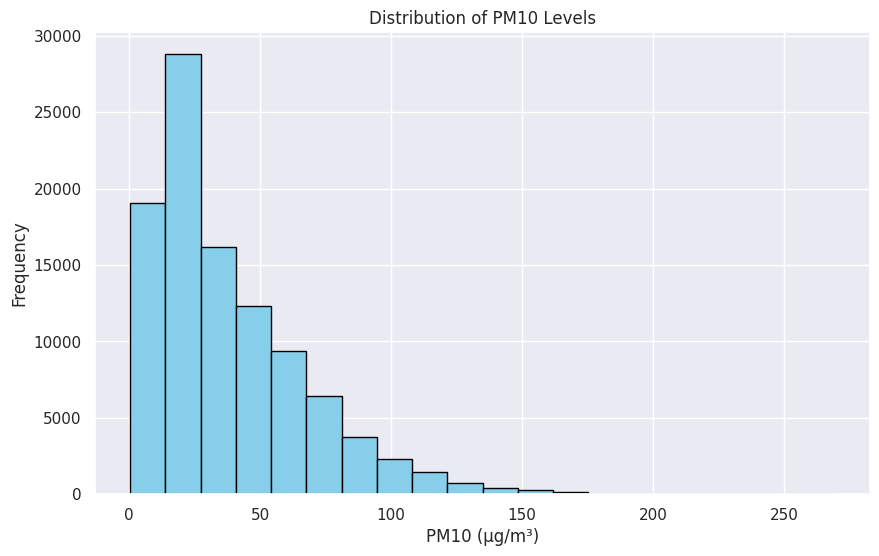

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(label['pm10 (μg/m³)'], bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of PM10 Levels')
plt.xlabel('PM10 (μg/m³)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Berdasarkan grafik distribusi PM10, dapat dilihat bahwa PM10 memiliki distribusi positively skewed. Yang artinya, terdapat outlier pada kolom PM10. Namun, saya memilih untuk tidak mencoba untuk menangani outlier dari kolom tersebut supaya model dapat lebih terbiasa dengan anomali yang ada pada data.

**Test**

In [ ]:
airqual_test[2].head()

,carbon_monoxide (μg/m³),nitrogen_dioxide (μg/m³),sulphur_dioxide (μg/m³),ozone (μg/m³),dust (μg/m³),uv_index (),uv_index_clear_sky ()
available_at,,,,,,,
2023-10-01 00:00:00,937.0,39.4,38.1,111.0,0.0,0.0,0.0
2023-10-01 01:00:00,1023.0,47.2,43.9,88.0,0.0,0.0,0.0
2023-10-01 02:00:00,1210.0,54.3,49.3,69.0,0.0,0.0,0.0
2023-10-01 03:00:00,1610.0,60.5,54.0,57.0,0.0,0.0,0.0
2023-10-01 04:00:00,2111.0,66.1,58.2,49.0,0.0,0.0,0.0


In [ ]:
airqual_test[2].describe()

,carbon_monoxide (μg/m³),nitrogen_dioxide (μg/m³),sulphur_dioxide (μg/m³),ozone (μg/m³),dust (μg/m³),uv_index (),uv_index_clear_sky ()
count,3174.000000,3209.000000,3192.000000,3159.000000,3239.00000,3218.000000,3191.000000
mean,4145.884814,137.441976,91.320207,326.003704,0.03958,5.262368,8.806894
std,22083.414131,785.254341,469.997243,1723.945103,0.29294,45.257046,69.017686
min,-90444.000000,-4955.600000,-4396.600000,-4010.600000,-11.30000,-168.100000,-104.900000
25%,757.000000,25.800000,31.275000,33.000000,0.00000,0.000000,0.000000
50%,1339.500000,46.500000,42.400000,60.000000,0.00000,0.000000,0.000000
75%,2518.750000,69.300000,55.800000,144.500000,0.00000,3.200000,5.200000
max,391191.400000,22799.500000,9065.000000,34299.600000,4.50000,1124.200000,1558.400000


In [ ]:
weather_test[2].head()

,temperature_2m (°C),relative_humidity_2m (%),dew_point_2m (°C),apparent_temperature (°C),rain (mm),pressure_msl (hPa),surface_pressure (hPa),cloud_cover (%),cloud_cover_low (%),cloud_cover_mid (%),cloud_cover_high (%),wind_speed_10m (km/h),wind_speed_100m (km/h),wind_direction_10m (°),wind_direction_100m (°),wind_gusts_10m (km/h)
available_at,,,,,,,,,,,,,,,,
2023-10-01 00:00:00,25.4,80.0,21.6,27.8,4.2,1012.4,1011.5,60.0,18.0,24.0,4824.9,15.3,26.3,204.0,203.0,34.2
2023-10-01 01:00:00,NaN,81.0,21.7,29.1,0.0,1013.2,1012.3,100.0,21.0,98.0,99.0,5.9,11.2,166.0,186.0,28.4
2023-10-01 02:00:00,480.3,83.0,22.2,29.6,0.0,1013.0,1012.1,90.0,0.0,100.0,100.0,4.6,11.0,225.0,221.0,15.5
2023-10-01 03:00:00,25.6,83.0,22.6,30.4,0.0,1012.8,1011.9,90.0,0.0,100.0,99.0,308.7,10.5,2565.9,218.0,10.4
2023-10-01 04:00:00,NaN,85.0,22.9,30.3,NaN,NaN,1011.4,69.0,0.0,68.0,95.0,5.1,458.8,225.0,225.0,11.2


In [ ]:
weather_test[2].describe()

,temperature_2m (°C),relative_humidity_2m (%),dew_point_2m (°C),apparent_temperature (°C),rain (mm),pressure_msl (hPa),surface_pressure (hPa),cloud_cover (%),cloud_cover_low (%),cloud_cover_mid (%),cloud_cover_high (%),wind_speed_10m (km/h),wind_speed_100m (km/h),wind_direction_10m (°),wind_direction_100m (°),wind_gusts_10m (km/h)
count,3118.000000,3194.000000,3113.000000,3195.000000,3125.000000,3128.000000,3197.000000,3144.000000,3183.000000,3207.000000,3170.000000,3163.000000,3203.000000,3136.000000,3188.000000,3176.000000
mean,106.697947,246.748215,72.232316,104.816620,1.210176,2684.139035,3924.218111,172.572933,37.479830,54.013128,287.662114,18.627822,25.808086,640.319611,616.436826,47.581486
std,412.075857,1058.539335,307.529733,466.191883,14.683988,11433.650473,16030.473837,802.296766,371.723149,359.939737,1293.077141,91.212606,125.230742,2864.363502,2825.372256,231.756293
min,-1457.700000,-2354.400000,-1619.900000,-3001.000000,-13.500000,-38226.900000,-54835.000000,-2139.100000,-1113.300000,-795.600000,-5165.200000,-955.200000,-1464.800000,-6941.300000,-8647.100000,-894.700000
25%,25.000000,69.000000,23.000000,30.200000,0.000000,1009.300000,1008.400000,29.000000,0.000000,3.000000,56.000000,3.600000,5.800000,131.750000,123.000000,9.000000
50%,26.900000,84.000000,23.700000,32.100000,0.000000,1010.600000,1009.700000,38.000000,4.000000,11.000000,98.000000,5.400000,9.500000,219.000000,221.000000,14.400000
75%,30.700000,94.000000,24.200000,35.200000,0.100000,1011.900000,1011.100000,58.250000,13.000000,27.000000,100.000000,8.900000,14.200000,276.000000,272.000000,23.800000
max,5030.400000,14880.300000,4412.000000,5636.100000,490.400000,138295.000000,198441.200000,12909.800000,13500.600000,10392.200000,17144.800000,1703.000000,1968.900000,42127.900000,36262.200000,3701.100000


# **Preprocessing Pertama**

Langkah awal yang saya lakukan adalah set index untuk data

In [ ]:
label = pd.read_csv('label.csv')
id = label['id']
label['available_at'] = id
label = label.drop('id',axis=1).set_index('available_at')

###**Lag Features and Concating The Data**

Lalu akan dilakukan concating pada 10 data yang ada.

In [ ]:
def lag_and_concat_airqual_data(data):
    airqual_10 = pd.read_csv(f'airqual_loc10_{data}.csv')
    airqual_10['available_at'] = airqual_10['available_at'].map(lambda x: f'{x}_loc10')
    airqual_10 = airqual_10.set_index('available_at')
    for i in airqual_10.columns:
        airqual_10[i] = airqual_10[i].shift(periods=-4)


    for i in range(9,0,-1):
        airqual_loc = pd.read_csv(f'airqual_loc0{i}_{data}.csv')
        airqual_loc['available_at'] = airqual_loc['available_at'].map(lambda x: f'{x}_loc0{i}')
        airqual_loc = airqual_loc.set_index('available_at')
        for i in airqual_loc.columns:
            airqual_loc[i] = airqual_loc[i].shift(periods=-4)
        airqual_10 = pd.concat([airqual_loc,airqual_10], axis=0)

    return airqual_10

airqual_train = lag_and_concat_airqual_data('train')
airqual_test = lag_and_concat_airqual_data('test')

In [ ]:
def lag_and_concat_weather_data(data):
    weather_10 = pd.read_csv(f'weather_loc10_{data}.csv')
    weather_10['available_at'] = weather_10['available_at'].map(lambda x: f'{x}_loc10')
    weather_10 = weather_10.set_index('available_at')
    for i in weather_10.columns:
        weather_10[i] = weather_10[i].shift(periods=-4)

    for i in range(9,0,-1):
        weather_loc = pd.read_csv(f'weather_loc0{i}_{data}.csv')
        weather_loc['available_at'] = weather_loc['available_at'].map(lambda x: f'{x}_loc0{i}')
        weather_loc = weather_loc.set_index('available_at')

        for i in weather_loc.columns:
            weather_loc[i] = weather_loc[i].shift(periods=-4)
        weather_10 = pd.concat([weather_loc,weather_10], axis=0)

    return weather_10

weather_train = lag_and_concat_weather_data('train')
weather_test = lag_and_concat_weather_data('test')

In [ ]:
merged_train = pd.merge(airqual_train, weather_train, on='available_at', how='left')
merged_test = pd.merge(airqual_test, weather_test, on='available_at', how='left')

### **Imputing with Iterative Imputer**

Berdasarkan hasil EDA pertama, ditemukan banyak sekali Nan values, sehingga saya melakukan eksperimen untuk menggunakan Iterative imputer dan juga KNNImputer untuk mengetahui imputer terbaik. Alasan saya memilih kedua imputer ini adalah iterative imputer bekerja dengan memodelkan setiap fitur dengan nilai yang hilang sebagai fungsi dari fitur lain dalam cara yang berulang. Keunggulan dari metode ini adalah bahwa imputer ini menggunakan seluruh set fitur yang tersedia untuk memperkirakan nilai yang hilang.

Sementara itu, KNN Imputer mengisi nilai yang hilang dengan menggunakan nilai rata-rata dari n_neighbors tetangga terdekat yang ditemukan dalam set training. Keunggulan dari metode ini adalah bahwa ia berdasarkan pada korelasi dengan semua fitur lainnya dan bukan hanya satu fitur.

In [ ]:
columns = merged_train.columns
index = merged_train.index
imputer = IterativeImputer()

merged_train = imputer.fit_transform(merged_train)
merged_train = pd.DataFrame(merged_train, columns=columns,index=index)


merged_train = pd.merge(merged_train, label,on='available_at', how='left')

In [ ]:
columns = merged_test.columns
index = merged_test.index

merged_test = imputer.transform(merged_test)
merged_test = pd.DataFrame(merged_test, columns=columns,index=index)

### **Imputing with KNNImputer**

In [ ]:
columns = merged_train.columns
index = merged_train.index
imputer = IterativeImputer()

merged_train = imputer.fit_transform(merged_train)
merged_train = pd.DataFrame(merged_train, columns=columns,index=index)


merged_train = pd.merge(merged_train, label,on='available_at', how='left')

In [ ]:
columns = merged_test.columns
index = merged_test.index

merged_test = imputer.transform(merged_test)
merged_test = pd.DataFrame(merged_test, columns=columns,index=index)

# **Exploratory Data Analysis (EDA) Kedua** 📊

**Train**

In [ ]:
merged_train_split = np.array_split(merged_train, 10)

Data yang sudah di merge, kembali di split untuk dilakukan EDA 2. Seperti pada EDA 1, saya akan mengambil loc_2 sebagai representasi dari data.

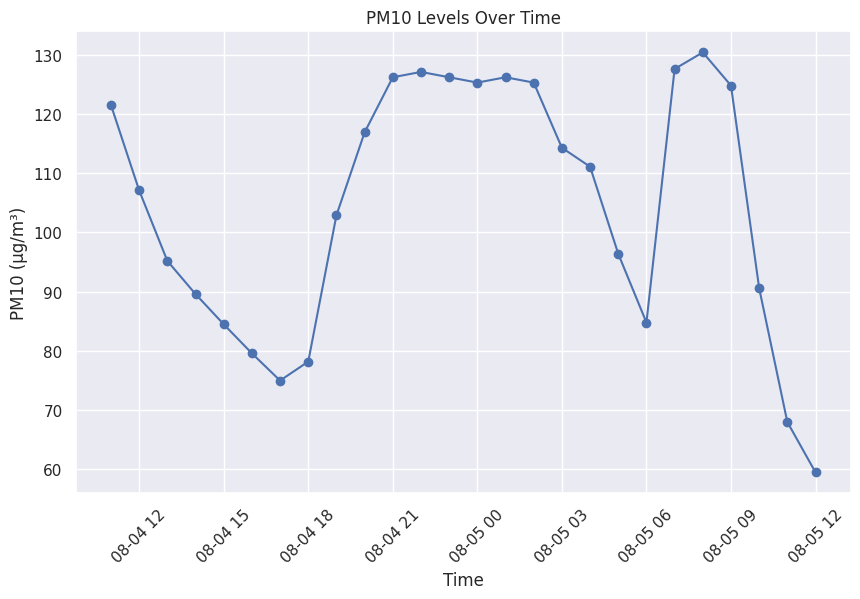

In [ ]:
merged_train_split[1].index = pd.to_datetime(merged_train_split[1].index.astype(str).str.split('_').str[0])

start_time = pd.to_datetime('2022-08-04 11:00:00')
end_time = pd.to_datetime('2022-08-05 12:00:00')

filtered_data = merged_train_split[1][(merged_train_split[1].index >= start_time) & (merged_train_split[1].index <= end_time)]

plt.figure(figsize=(10, 6))
plt.plot(filtered_data.index, filtered_data['pm10 (μg/m³)'], marker='o')
plt.title('PM10 Levels Over Time')
plt.xlabel('Time')
plt.ylabel('PM10 (μg/m³)')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()


Untuk membuat fitur baru, diperlukan pengamatan terhadap nilai PM10 di tiap jam nya. Berdasarkan grafik, bisa dilihat bahwa distribusi mencapai puncak pada interval jam 6-8. Dari hal tersebut, bisa dilihat bahwa jam tersebut merupakan rush hour atau jam dimana orang mulai beraktivitas.

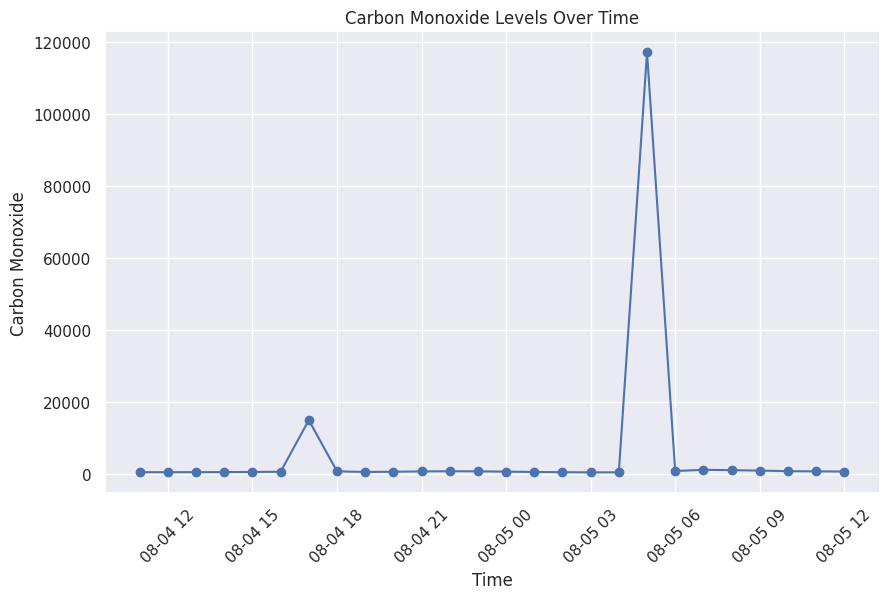

In [ ]:
merged_train_split[1].index = pd.to_datetime(merged_train_split[0].index)

start_time = pd.to_datetime('2022-08-04 11:00:00')
end_time = pd.to_datetime('2022-08-05 12:00:00')
filtered_data = merged_train_split[0].loc[start_time:end_time]

plt.figure(figsize=(10,6))
plt.plot(filtered_data.index, filtered_data["carbon_monoxide (μg/m³)"], marker='o')
plt.title('Carbon Monoxide Levels Over Time')
plt.xlabel('Time')
plt.ylabel('Carbon Monoxide')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

Berdasarkan grafik, data terdistribusi di kisaran angka 1000-2000. Namun, pada grafik terlihat bahwa terdapat 1 waktu yang angkanya hampir menyentuh 120.000. Titik tersebut bisa disimpulkan sebagai outlier.Selain itu, bisa kita ketahui bahwa terdapat rush hour yang lainnya, yaitu dari jam 3 sore hingga 6 sore.

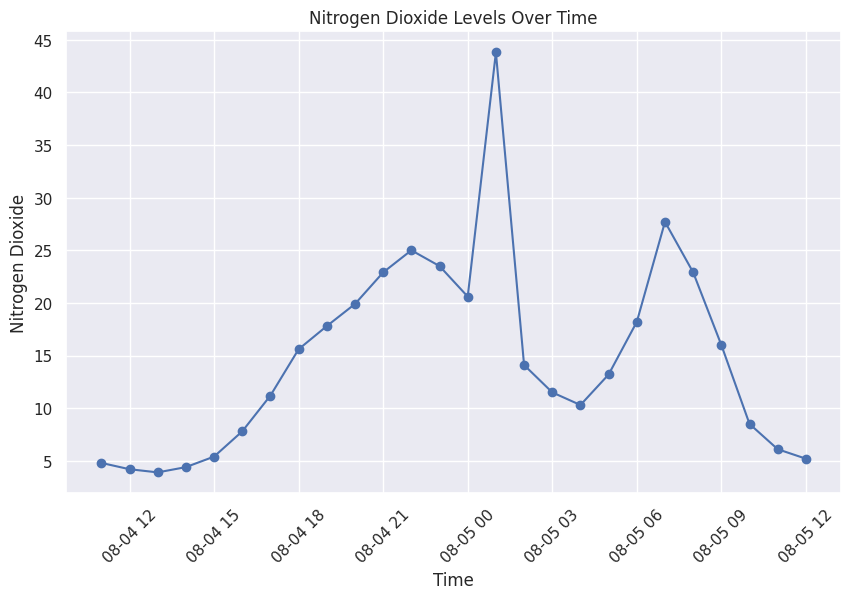

In [ ]:
merged_train_split[1].index = pd.to_datetime(merged_train_split[0].index)

start_time = pd.to_datetime('2022-08-04 11:00:00')
end_time = pd.to_datetime('2022-08-05 12:00:00')
filtered_data = merged_train_split[0].loc[start_time:end_time]

plt.figure(figsize=(10,6))
plt.plot(filtered_data.index, filtered_data["nitrogen_dioxide (μg/m³)"], marker='o')
plt.title('Nitrogen Dioxide Levels Over Time')
plt.xlabel('Time')
plt.ylabel('Nitrogen Dioxide')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

Sama halnya seperti carbon monoxide, distribusi nitrogen dioxide berada di puncak saat rush hour, yaitu interval jam 6-9 dan jam 12-15. Namun, max point dari grafik berada di jam 1 pagi. Hal ini disebabkan karena tingginya kelembapan udara di waktu malam hari dan pagi hari. Kelembapan yang tinggi memiliki hubungan yang kuat dengan nitrogen dioxide.

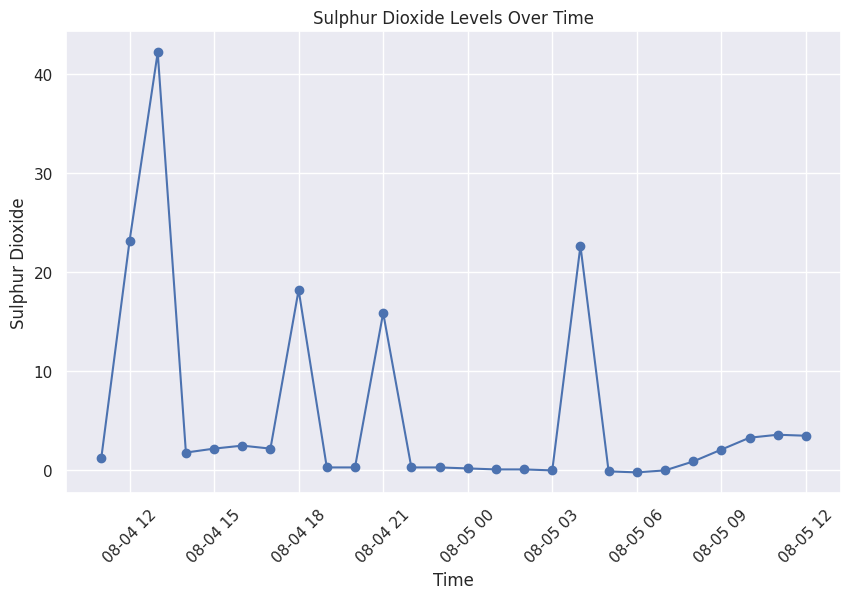

In [ ]:
merged_train_split[1].index = pd.to_datetime(merged_train_split[0].index)

start_time = pd.to_datetime('2022-08-04 11:00:00')
end_time = pd.to_datetime('2022-08-05 12:00:00')
filtered_data = merged_train_split[0].loc[start_time:end_time]

plt.figure(figsize=(10,6))
plt.plot(filtered_data.index, filtered_data["sulphur_dioxide (μg/m³)"], marker='o')
plt.title('Sulphur Dioxide Levels Over Time')
plt.xlabel('Time')
plt.ylabel('Sulphur Dioxide')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

Berdasarkan grafik, bisa dilihat bahwa distribusi sulfur dioksida mengalami fluktuasi. Namun dapat terlihat, nilai dari sulfur dioksida meningkat secara bertahap pada rush hour.

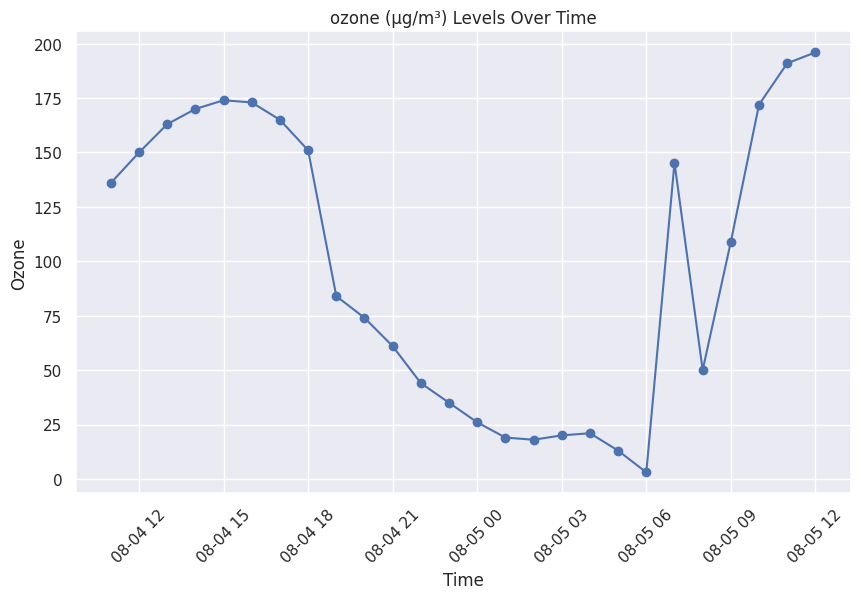

In [ ]:
merged_train_split[1].index = pd.to_datetime(merged_train_split[0].index)

start_time = pd.to_datetime('2022-08-04 11:00:00')
end_time = pd.to_datetime('2022-08-05 12:00:00')
filtered_data = merged_train_split[0].loc[start_time:end_time]

plt.figure(figsize=(10,6))
plt.plot(filtered_data.index, filtered_data["ozone (μg/m³)"], marker='o')
plt.title('ozone (μg/m³) Levels Over Time')
plt.xlabel('Time')
plt.ylabel('Ozone')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

Berdasarkan grafik, bisa dilihat bahwa nilai dari ozone mengalami peningkatan di fase rush hour dan penurunan pada jam 19.00 - jam 05.00

<Axes: >

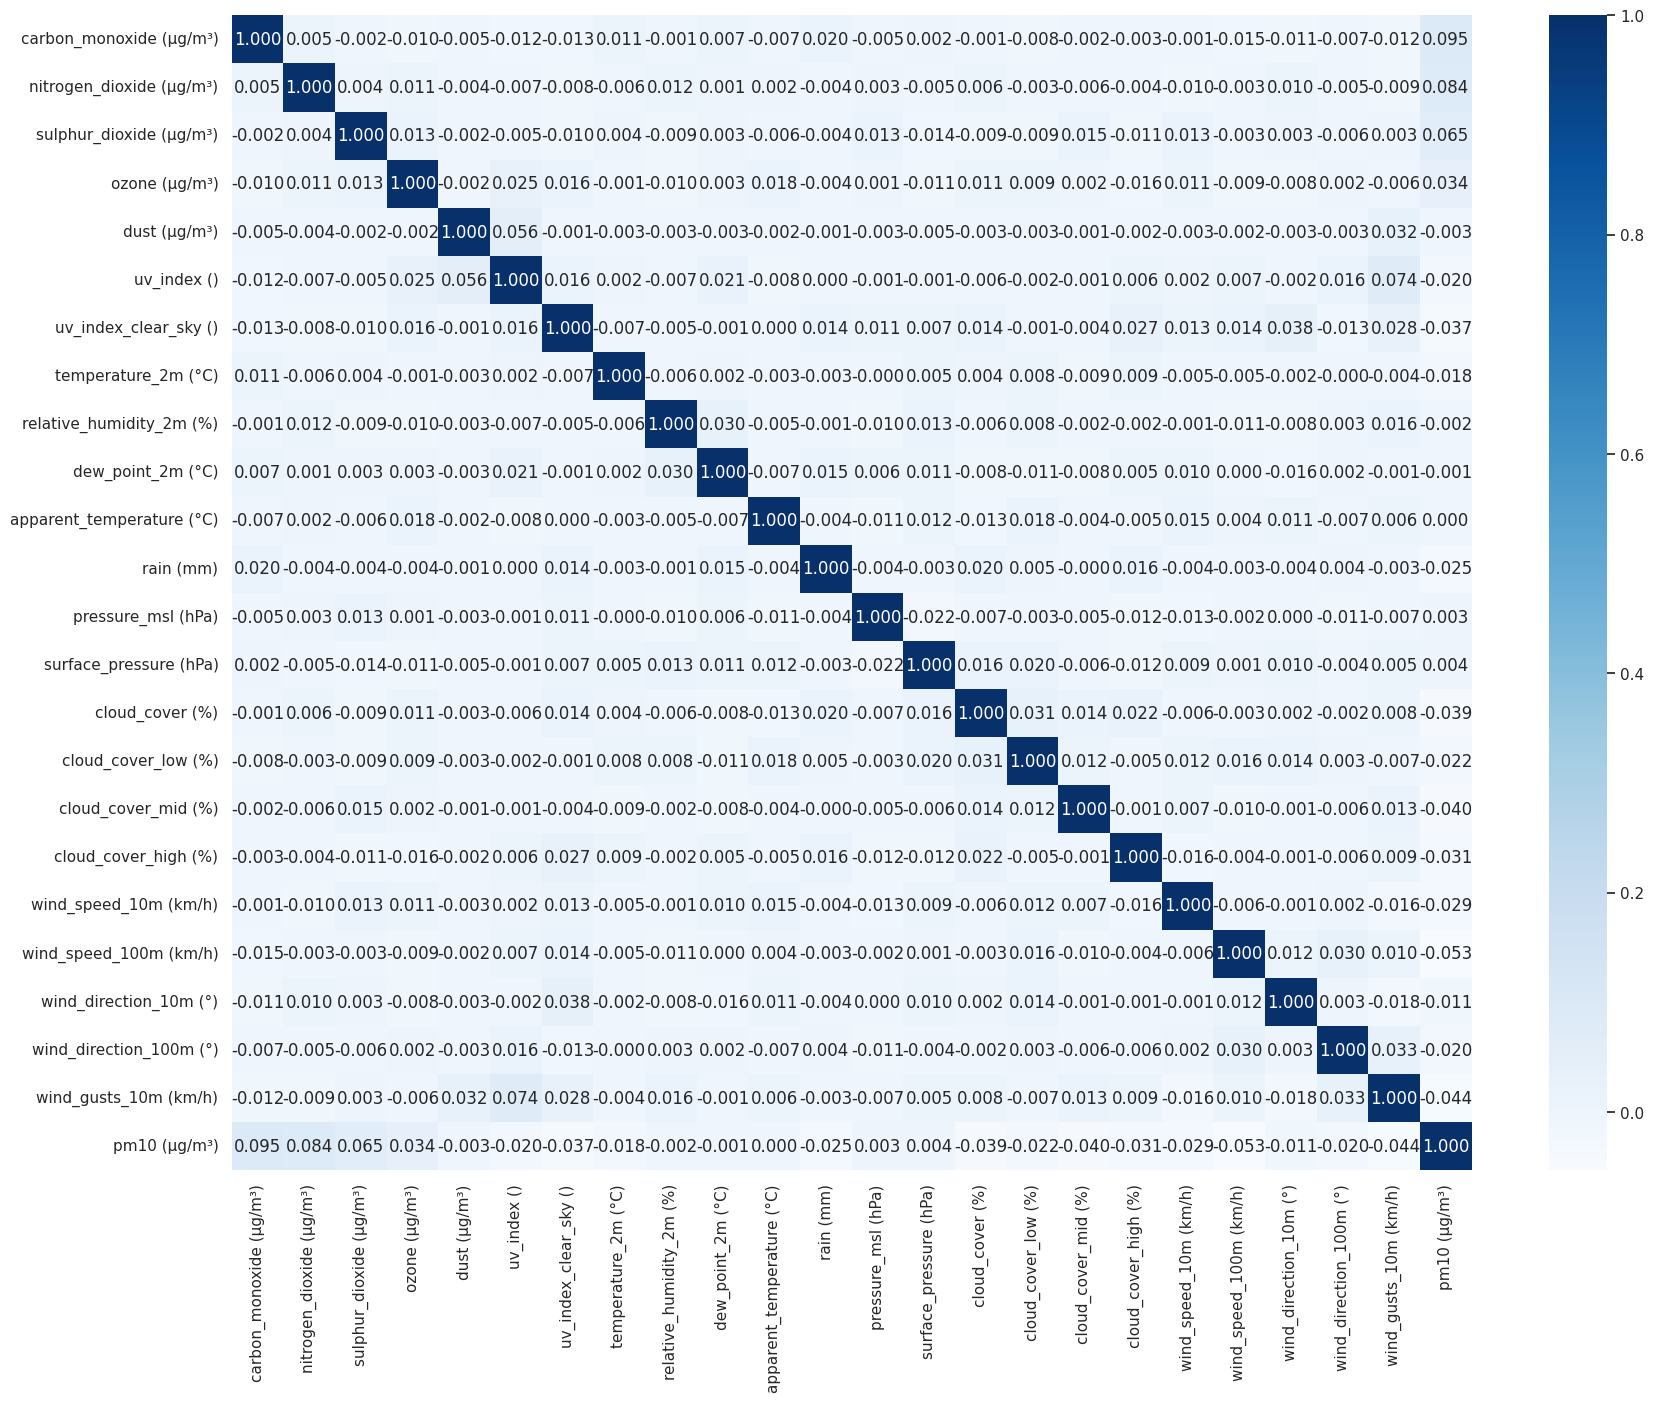

In [ ]:
plt.figure(figsize=(20,15))
sns.heatmap(merged_train_split[1].corr(), cmap = 'Blues', annot= True, fmt='.3f')

Terlihat bahwa korelasi antar fitur tidak begitu baik sehingga diperlukan fitur baru supaya model dapat memiliki performans yang lebih baik dalam melakukan prediksi.

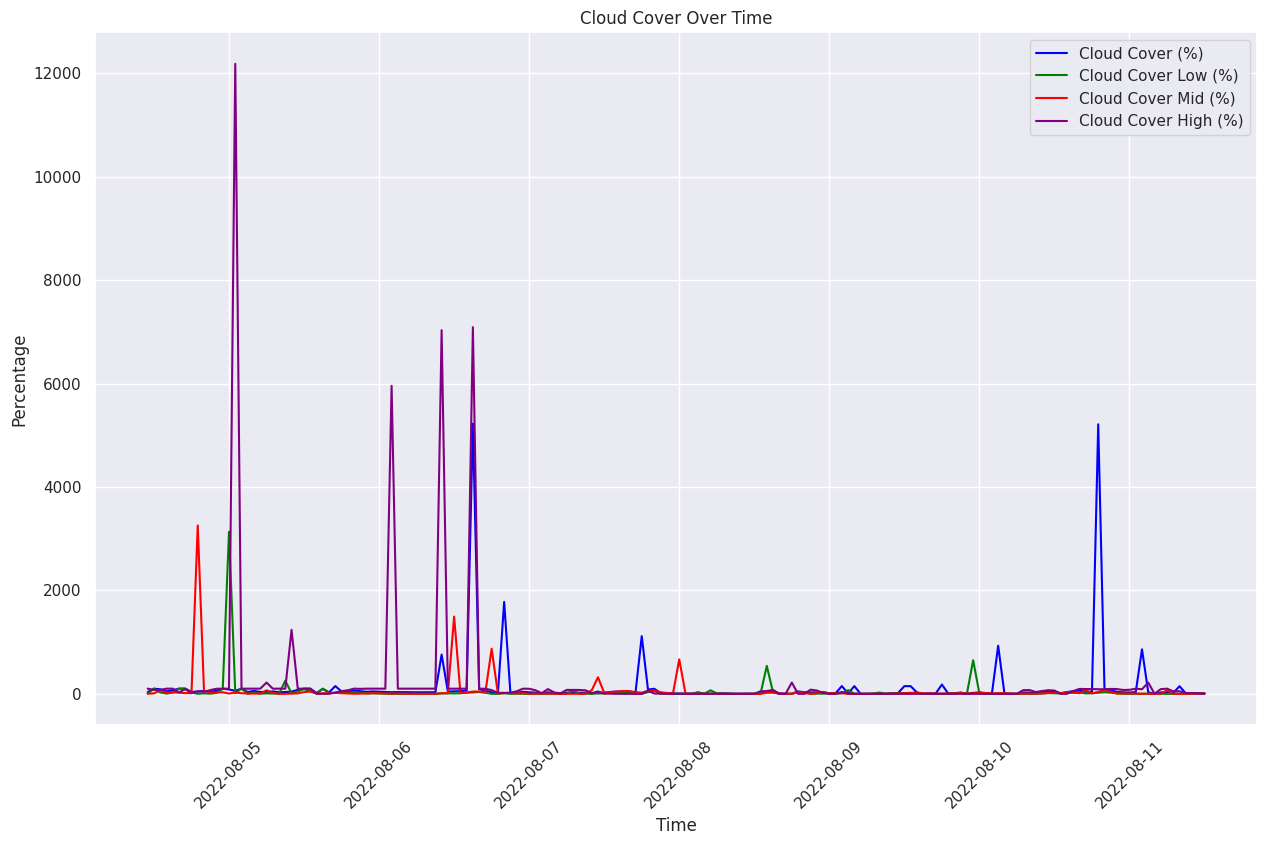

In [ ]:
merged_train_split[1].index = pd.to_datetime(merged_train_split[1].index)

start_time = pd.to_datetime('2022-08-04 11:00:00')
end_time = pd.to_datetime('2022-08-11 12:00:00')

filtered_data = merged_train_split[1].loc[start_time:end_time]

plt.figure(figsize=(15,9))
plt.plot(filtered_data.index, filtered_data["cloud_cover (%)"], label='Cloud Cover (%)', color='blue')
plt.plot(filtered_data.index, filtered_data["cloud_cover_low (%)"], label='Cloud Cover Low (%)', color='green')
plt.plot(filtered_data.index, filtered_data["cloud_cover_mid (%)"], label='Cloud Cover Mid (%)', color='red')
plt.plot(filtered_data.index, filtered_data["cloud_cover_high (%)"], label='Cloud Cover High (%)', color='purple')

plt.title('Cloud Cover Over Time')
plt.xlabel('Time')
plt.ylabel('Percentage')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)

plt.show()

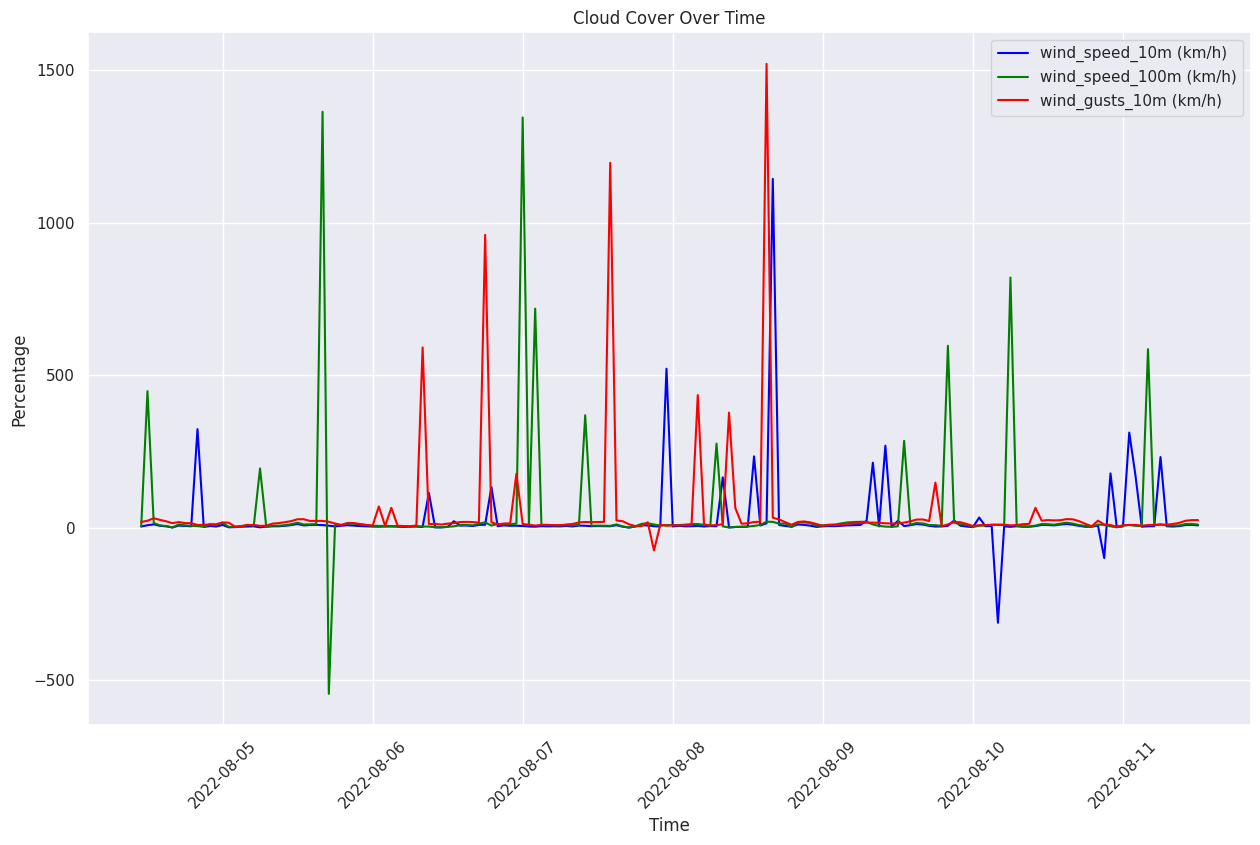

In [ ]:
merged_train_split[1].index = pd.to_datetime(merged_train_split[1].index)

start_time = pd.to_datetime('2022-08-04 11:00:00')
end_time = pd.to_datetime('2022-08-11 12:00:00')

filtered_data = merged_train_split[1].loc[start_time:end_time]

plt.figure(figsize=(15,9))
plt.plot(filtered_data.index, filtered_data["wind_speed_10m (km/h)"], label='wind_speed_10m (km/h)', color='blue')
plt.plot(filtered_data.index, filtered_data["wind_speed_100m (km/h)"], label='wind_speed_100m (km/h)', color='green')
plt.plot(filtered_data.index, filtered_data["wind_gusts_10m (km/h)"], label='wind_gusts_10m (km/h)', color='red')

plt.title('Cloud Cover Over Time')
plt.xlabel('Time')
plt.ylabel('Percentage')
plt.grid(True)
plt.legend()
plt.xticks(rotation=45)

plt.show()

Disaat, angin mengalami kenaikan, maka skor pm10 juga mengalami kenaikan. Hal tersebut dikarenakan angin merupakan media yang berperan dalam mendistribusikan zat-zat polutan. Selain itu, cloud cover mengindikasikan peluang untuk turunnya hujan disuatu lokasi. Disaat cloud cover tinggi, maka kemungkinan hujan untuk turun pun tinggi.

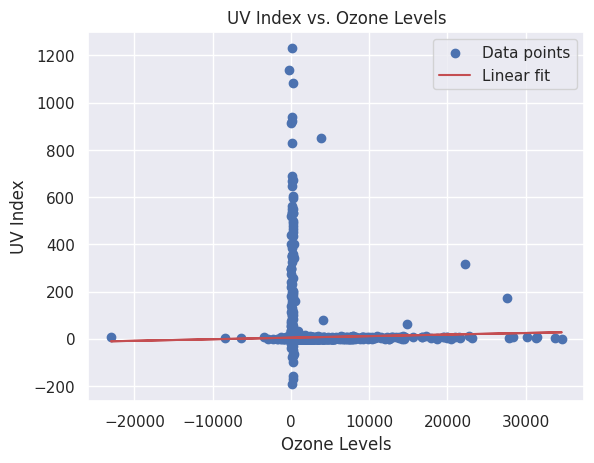

In [ ]:
plt.scatter(merged_train_split[1]['ozone (μg/m³)'], merged_train_split[1]['uv_index ()'], color='b', label='Data points')

coefficients = np.polyfit(merged_train_split[1]['ozone (μg/m³)'], merged_train_split[1]['uv_index ()'], 1)
regression_line = np.poly1d(coefficients)
plt.plot(merged_train_split[1]['ozone (μg/m³)'], regression_line(merged_train_split[1]['ozone (μg/m³)']), color='r', label='Linear fit')

plt.xlabel('Ozone Levels')
plt.ylabel('UV Index')
plt.title('UV Index vs. Ozone Levels')
plt.grid(True)
plt.legend()

plt.show()

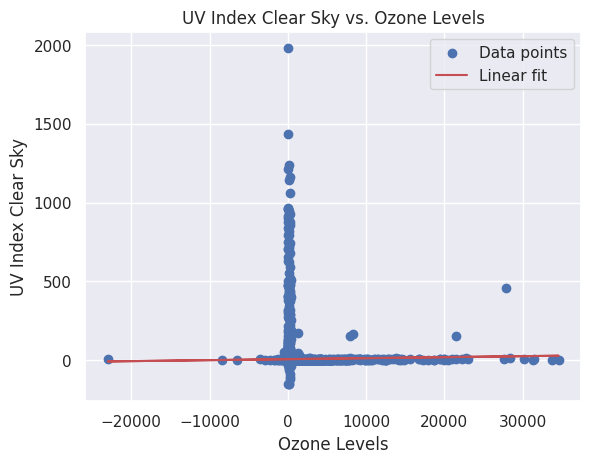

In [ ]:
plt.scatter(merged_train_split[1]['ozone (μg/m³)'], merged_train_split[1]['uv_index_clear_sky ()'], color='b', label='Data points')

coefficients = np.polyfit(merged_train_split[1]['ozone (μg/m³)'], merged_train_split[1]['uv_index_clear_sky ()'], 1)
regression_line = np.poly1d(coefficients)
plt.plot(merged_train_split[1]['ozone (μg/m³)'], regression_line(merged_train_split[1]['ozone (μg/m³)']), color='r', label='Linear fit')

plt.xlabel('Ozone Levels')
plt.ylabel('UV Index Clear Sky')
plt.title('UV Index Clear Sky vs. Ozone Levels')
plt.grid(True)
plt.legend()

plt.show()

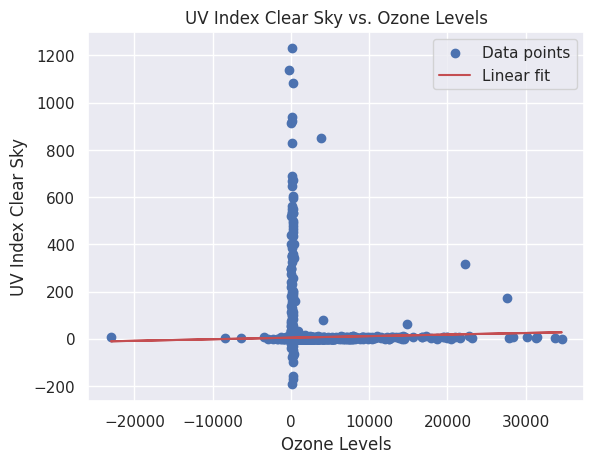

In [ ]:
plt.scatter(merged_train_split[1]['ozone (μg/m³)'], merged_train_split[1]['uv_index ()'], color='b', label='Data points')

coefficients = np.polyfit(merged_train_split[1]['ozone (μg/m³)'], merged_train_split[1]['uv_index ()'], 1)
regression_line = np.poly1d(coefficients)
plt.plot(merged_train_split[1]['ozone (μg/m³)'], regression_line(merged_train_split[1]['ozone (μg/m³)']), color='r', label='Linear fit')

plt.xlabel('Ozone Levels')
plt.ylabel('UV Index Clear Sky')
plt.title('UV Index Clear Sky vs. Ozone Levels')
plt.grid(True)
plt.legend()

plt.show()

Berdasarkan grafik tersebut, dapat dilihat bahwa fitur-fitur seperti ozone, index uv, dan index uv clear sky memiliki linearity sehingga dapat dibentuk suatu fitur antara index uv dengan ozone yang dapat memberikan suatu pengaruh terhadap hasil prediksi

# **Preprocessing Kedua dan Feature Engineering**

## **Weather Feature**

**Used Features**

Pada data, terdapat fitur wind_direction yang bersifat siklis sehingga saya bisa memanfaatkan fitur wind speed menjadi vektor. Model tidak bisa memahami bahwa jarak dari 0° lebih dekat ke 359° dibanding 10°. Selain itu, seperti yang kita ketahui, angin merupakah salah satu properti untuk mendistribusi polusi udara.

In [ ]:
def wind_features(_df:pd.DataFrame) -> pd.DataFrame:
    df = _df.copy()

    wv10 = df.pop('wind_speed_10m (km/h)')
    wd_rad10 = df.pop('wind_direction_10m (°)')*np.pi / 180

    df['wind_x_10'] = wv10*np.cos(wd_rad10)
    df['wind_y_10'] = wv10*np.sin(wd_rad10)

    wv100 = df.pop('wind_speed_100m (km/h)')
    wd_rad100 = df.pop('wind_direction_100m (°)')*np.pi / 180

    df['wind_x_100'] = wv100*np.cos(wd_rad100)
    df['wind_y_100'] = wv100*np.sin(wd_rad100)

    return df

merged_train = wind_features(merged_train)
merged_test = wind_features(merged_test)

Perbedaan tekanan udara antara laut dan darat menciptakan angin darat dan angin laut. Angin ini bergerak dari area bertekanan tinggi ke area bertekanan rendah. Selama siang hari, daratan menyerap lebih cepat energi panas dari sinar matahari sehingga tekanan udaranya menjadi lebih rendah dibandingkan dengan laut. Hal ini menciptakan angin laut yang bergerak dari laut (bertekanan tinggi) ke darat (bertekanan rendah). Sebaliknya, pada malam hari, daratan lebih cepat mendingin sehingga tekanan udaranya menjadi lebih tinggi dibandingkan dengan laut. Hal ini menciptakan angin darat yang bergerak dari darat (bertekanan tinggi) ke laut (bertekanan rendah). Angin darat dan angin laut ini dapat membawa polutan (partikel polusi udara) dari satu tempat ke tempat lain.


In [ ]:
def pressure_diff(_df: pd.DataFrame) -> pd.DataFrame:
    df = _df.copy()
    df["pres_diff"] = df["pressure_msl (hPa)"]-df["surface_pressure (hPa)"]
    return df

merged_train = pressure_diff(merged_train)
merged_test = pressure_diff(merged_test)

Fitur perbedaan temperature dibuat supaya model dapat menangkap bahwa apparent temperatue memiliki korelasi yang tinggi dengan temperature asli dan fitur lainnya yang ada pada data

In [ ]:
def temperature_diff(_df: pd.DataFrame) -> pd.DataFrame:
  df = _df.copy()
  df["temp_diff"] = df['apparent_temperature (°C)'] - df['temperature_2m (°C)']
  return df

merged_train = temperature_diff(merged_train)
merged_test = temperature_diff(merged_test)

**Unused Features**

Fitur cloud category dibuat untuk mengategorikan tingkat suatu langit ditutupi oleh awan. Apabila kondisi langit ditutupi awan, maka peluang untuk hujan turun pun tinggi. Fitur ini dibuat supaya model dapat mengenali pola hujan yang dialami oleh suatu kota. Hujan dapat membantu mengencerkan polutan di udara dengan konsentrasi tinggi. Karena materi partikulat kasar (PM10) seperti debu, kotoran, dan serbuk sari lebih besar dan lebih berat daripada partikel lainnya, hujan dapat membantu PM10 mengendap di tanah. Namun, fitur ini kurang dapat membantu model menangkap pola hujan karena one hot encoding membuat data memiliki lebih banyak kolom sehingga model sulit untuk membaca pattern dari datanya itu sendiri.

In [ ]:
def cloud_category(_df: pd.DataFrame) -> pd.DataFrame:
    df = _df.copy()
    cloud_columns = ["cloud_cover (%)", "cloud_cover_low (%)", "cloud_cover_mid (%)", "cloud_cover_high (%)"]

    for cloud in cloud_columns:
        df["no_clouds_" + cloud] = df[cloud].apply(lambda x: 1 if x == 0 else 0)
        df["few_" + cloud] = df[cloud].apply(lambda x: 1 if 0 < x <= 10 else 0)
        df["isolated_" + cloud] = df[cloud].apply(lambda x: 1 if 10 < x <= 25 else 0)
        df["scattered_" + cloud] = df[cloud].apply(lambda x: 1 if 25 < x <= 50 else 0)
        df["broken_" + cloud] = df[cloud].apply(lambda x: 1 if 50 < x <= 90 else 0)
        df["overcast_" + cloud] = df[cloud].apply(lambda x: 1 if x > 90 else 0)

    return df

merged_train = {i: cloud_category(df) for i, df in merged_train.items()}
merged_test = {i: cloud_category(df) for i, df in merged_test.items()}

Setelah membuat baseline model, saya mencari feature importance dari data. Rain dan pressure memiliki tingkat feature importance yang tinggi sehingga saya menerapkan fitur polinomial dengan harapan fitur polinomial dapat membantu model dalam memahami dan memprediksi pola dalam data yang mungkin tidak dapat ditangkap oleh fitur linear. Namun, fitur polinomial ini meningkatkan kompleksitas model dan risiko overfitting karena terdapat noise pada data

In [ ]:
from ast import withitem
def polynomial_weather(_df: pd.DataFrame) -> pd.DataFrame :
    df = _df.copy()
    wth_lst = ["rain (mm)","pressure_msl (hPa)"]

    for wth in wth_lst :
        df[f"{wth}_squared"] = df[wth]**2

    return df

merged_train = {i: polynomial_subs(df) for i, df in merged_train.items()}
merged_test = {i: polynomial_subs(df) for i, df in merged_test.items()}

Status pengembunan atau kondisi kelembaban di atmosfer, dapat mempengaruhi polusi udara. Partikel polutan dapat menyerap uap air dan tumbuh menjadi partikel yang lebih besar. Ini dapat mempengaruhi sejauh mana partikel tersebut dapat menyebar dan berapa lama mereka tetap berada di udara.
Selain itu, kelembaban dapat memfasilitasi reaksi kimia tertentu di atmosfer. Misalnya, sulfur dioksida (SO2) dan nitrogen oksida (NOx), dua polutan udara utama, dapat bereaksi dengan uap air untuk membentuk asam sulfat dan asam nitrat. Namun, fitur ini tidak membantu model untuk mengenali pola data karena terdapat banyak hal yang bisa memengaruhi tingkat kelembapan pada suatu daerah

In [ ]:
def status_dew(_df: pd.DataFrame) -> pd.DataFrame:
    df = _df.copy()

    df["dew_status"] = df.apply(lambda row: 1 if row['temperature_2m (°C)'] < row['dew_point_2m (°C)'] else 0, axis=1)

    return df

merged_train = {i: status_dew(df) for i, df in merged_train.items()}
merged_test = {i: status_dew(df) for i, df in merged_test.items()}

## **Airqual Features**

**Used Features**

Fitur polinomial ini digunakan untuk menambah kompleksitas model dan memungkinkan model untuk mempelajari pola non-linear dalam data. Dalam konteks ini, fitur polinomial dapat membantu model memahami hubungan yang lebih kompleks antara NO2, SO2, CO dan polutan lainnya.

Walaupun kolom dust merupakan salah satu jenis substansi polusi, saya memilih untuk tidak menerapkan fitur polinomial pada kolom tersebut. Hal ini dikarenakan, kolom dust didominasi dengan angka 0 sehingga tidak akan membantu model untuk menangkap pola non linear.

In [ ]:
def polynomial_subs(_df: pd.DataFrame) -> pd.DataFrame :
    df = _df.copy()
    subs_lst = ["carbon_monoxide (μg/m³)", "nitrogen_dioxide (μg/m³)", "sulphur_dioxide (μg/m³)", "ozone (μg/m³)"]

    for subs in subs_lst :
        df[f"{subs}_squared"] = df[subs]**2

    return df

merged_train = polynomial_subs(merged_train)
merged_test = polynomial_subs(merged_test)

Seperti yang sudah diketahui, molekul kimia dapat saling berikatan yang nantinya akan membentuk komponen polusi yang lain. Fitur ini terbukti berhasil dengan menurunnya skor smappe pada public leaderboard dan tingginya nilai dari feature importance pada fitur ini.

In [ ]:
def interaction_terms(_df: pd.DataFrame) -> pd.DataFrame :
  df = _df.copy()

  df["no2o3_interaction"] =  df["nitrogen_dioxide (μg/m³)"] * df["ozone (μg/m³)"]
  df["so2no_interaction"] = df["nitrogen_dioxide (μg/m³)"] * df["sulphur_dioxide (μg/m³)"]
  df["no2co_intercation"] = df["nitrogen_dioxide (μg/m³)"] * df["carbon_monoxide (μg/m³)"]
  df["no2o3_interaction"] =  df["carbon_monoxide (μg/m³)"] * df["ozone (μg/m³)"]

  return df

merged_train = interaction_terms(merged_train)
merged_test = interaction_terms(merged_test)

Fitur ini merupakan fitur statistik bergulir dari kolom-kolom tertentu dalam DataFrame, yang bisa sangat berguna untuk membantu model dalam menganalisis time series atau masalah prediksi yang melibatkan data temporal. Fitur-fitur ini dapat membantu model untuk menangkap pola atau tren dalam data sepanjang waktu.

In [ ]:
from typing import List
lst = ['ozone (μg/m³)','carbon_monoxide (μg/m³)','nitrogen_dioxide (μg/m³)','sulphur_dioxide (μg/m³)']

def temporal_agg(_df: pd.DataFrame, lst: List[str], window_size: int = 3) -> pd.DataFrame:
    df = _df.copy()

    for col in lst:
        df[f'{col}_rolling_min'] = df[col].rolling(window=window_size, min_periods=1).min()
        df[f'{col}_rolling_mean'] = df[col].rolling(window=window_size, min_periods=1).mean()
        df[f'{col}_rolling_max'] = df[col].rolling(window=window_size, min_periods=1).max()

    return df

merged_train = temporal_agg(merged_train, lst)
merged_test = temporal_agg(merged_test, lst)

Zat ozon dapat menyerap kandungan UV di udara sehingga kita bisa mencari korelasi antara uv dengan ozon.

In [ ]:
def uv_feature(_df: pd.DataFrame) -> pd.DataFrame :
  df = _df.copy()

  df['UV_impact'] = df['uv_index ()'] * df['ozone (μg/m³)']
  df['clear_sky_UV_impact'] = df['uv_index_clear_sky ()'] * df['ozone (μg/m³)']

  return df

merged_train = uv_feature(merged_train)
merged_test = uv_feature(merged_test)

Berdasarkan data, dapat diketahui bahwa tingkat pm10 tertinggi adalah disaat weekday atau hari dimana terjadinya aktivitas industri, menaiknya penggunaan transportasi, dan lain sebagainya. Oleh karena itu, saya membuat fitur ini supaya model dapat mengenali pengaruh waktu terhadap naik atau turunnya PM10.

In [ ]:
def dayoftheweek(_df:pd.DataFrame) -> pd.DataFrame:
  df = _df.copy()
  index = df.index
  df.index = pd.to_datetime(df.index.str.split('_').str[0], format='%Y-%m-%d %H:%M:%S')
  df['weekday'] = df.index.weekday
  df['is_weekend'] = (df['weekday'] >= 5)
  df = df.set_index(index)
  return df

merged_train = dayoftheweek(merged_train)
merged_test = dayoftheweek(merged_test)

Waktu merupakan data yang bersifat siklis sehingga sama seperti fitur angin, saya juga membuat fitur siklis untuk waktu agar model dapat lebih baik dalam melakukan prediksi.

In [ ]:
def cyclical_weekday(_df: pd.DataFrame) -> pd.DataFrame:
    df = _df.copy()
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)
    return df

merged_train = cyclical_weekday(merged_train)
merged_test = cyclical_weekday(merged_test)

Terdapat beberapa componen yang dapat saling berikatan dan menyebabkan polutan yang lainnya. Seperti contoh, nitrogen sulfur yang merupakan hasil antara ikatan nitrogen dioksida dan sulfur dioksida. Dan juga, karbon monoksida dapat berikatan dengan ozon yang nantinya dapat menjadi salah satu polutan di udara.



In [ ]:
def nitrogen_sulphur_ratio(_df: pd.DataFrame) -> pd.DataFrame :
    df = _df.copy()
    df['nit/sulph_ratio'] = df['nitrogen_dioxide (μg/m³)']/df['sulphur_dioxide (μg/m³)']

    return df

merged_train = nitrogen_sulphur_ratio(merged_train)
merged_test = nitrogen_sulphur_ratio(merged_test)

In [ ]:
def carbon_ozone_ratio(_df: pd.DataFrame) -> pd.DataFrame :
    df = _df.copy()
    df['carb/ozone_ratio'] = df['carbon_monoxide (μg/m³)']/df['ozone (μg/m³)']

    return df

merged_train = carbon_ozone_ratio(merged_train)
merged_test = carbon_ozone_ratio(merged_test)

Fitur ini dibuat karena saya menggabungkan 10 data yang sudah ada di setiap lokasi. Dengan digabungkannya data, maka model akan mendapatkan lebih banyak data points sehingga meningkatkan performannya dalam memprediksi. FItur location dapat membantu agar model tetap dapat mengenali bahwa hasil penggabungan tersebut merupakan data dari tempat yang berbeda.

In [ ]:
def location(_df: pd.DataFrame) -> pd.DataFrame:
    df = _df.copy()
    df['location'] = df.index.str[-2:].map(lambda x: int(x))
    return df

merged_train = location(merged_train)
merged_test = location(merged_test)

**Unused Features**

Pada awalnya, fitur ini dibuat karena meningkatnya skor PM10 pada skala waktu pagi dan juga siang sehingga saya melakukan onehot encoding supaya model dapat lebih mengenali data. Namun, fitur ini tampaknya hanya memberikan noise kepada data karena saya membuat 3 kolom baru. Hal ini, saya ketahui setelah mencari feature importance dari model LGBM.

In [ ]:
def timeoftheday(_df:pd.DataFrame) -> pd.DataFrame :
  df = _df.copy()
  df['hour'] = df.index.hour
  df['is_morning'] = (df['hour'] >= 6) & (df['hour'] < 12)
  df['is_afternoon'] = (df['hour'] >= 12) & (df['hour'] < 18)
  df['is_evening'] = (df['hour'] >= 18) & (df['hour'] < 24)

  df['is_morning'] = df['is_morning'].astype(int)
  df['is_afternoon'] = df['is_afternoon'].astype(int)
  df['is_evening'] = df['is_evening'].astype(int)

  return df


merged_train = {i: timeoftheday(df) for i, df in merged_train.items()}
merged_test = {i: timeoftheday(df) for i, df in merged_test.items()}

Berdasarkan data pada laman : https://openweathermap.org/api/air-pollution#current, Kita bisa melihat bahwa terdapat index score untuk mengategorisasikan polusi yang beredar di udara. Namun, fitur ini tampaknya memberi noise kepada data karena banyaknya kolom yang dibuat untuk membuat fitur ini. Fitur ini menerapkan ordinal encoding dalam penerapannya.

In [ ]:
def so2_category(_df:pd.DataFrame) -> pd.DataFrame :
  df = _df.copy()

  def categorize(x):
    if 0 <= x < 20:
      return 1
    elif 20 <= x < 80:
      return 2
    elif 80 <= x < 250:
      return 3
    elif 250 <= x < 350:
      return 4
    else:
      return 5

  df["so2_category"] = df['sulphur_dioxide (μg/m³)'].apply(categorize)

  return df

merged_train = {i: so2_category(df) for i, df in merged_train.items()}
merged_test = {i: so2_category(df) for i, df in merged_test.items()}

In [ ]:
def no2_category(_df:pd.DataFrame) -> pd.DataFrame :
  df = _df.copy()

  def categorize(x):
    if 0 <= x < 40:
      return 1
    elif 40 <= x < 70:
      return 2
    elif 70 <= x < 150:
      return 3
    elif 150 <= x < 200:
      return 4
    else:
      return 5

  df["no2_category"] = df['nitrogen_dioxide (μg/m³)'].apply(categorize)

  return df


merged_train = {i: no2_category(df) for i, df in merged_train.items()}
merged_test = {i: no2_category(df) for i, df in merged_test.items()}

In [ ]:
def o3_category(_df:pd.DataFrame) -> pd.DataFrame :
  df = _df.copy()

  def categorize(x):
    if 0 <= x < 60:
      return 1
    elif 60 <= x < 100:
      return 2
    elif 100 <= x < 140:
      return 3
    elif 140 <= x < 180:
      return 4
    else:
      return 5

  df["o3_category"] = df['ozone (μg/m³)'].apply(categorize)

  return df

merged_train = {i: o3_category(df) for i, df in merged_train.items()}
merged_test = {i: o3_category(df) for i, df in merged_test.items()}

In [ ]:
def co_category(_df:pd.DataFrame) -> pd.DataFrame :
  df = _df.copy()

  def categorize(x):
    if 0 <= x < 4400:
      return 1
    elif 4400 <= x < 9400:
      return 2
    elif 9400 <= x < 12400:
      return 3
    elif 12400 <= x < 15400:
      return 4
    else:
      return 5

  df["co_category"] = df['carbon_monoxide (μg/m³)'].apply(categorize)

  return df

merged_train = {i: co_category(df) for i, df in merged_train.items()}
merged_test = {i: co_category(df) for i, df in merged_test.items()}

In [ ]:
def result_index(_df:pd.DataFrame) -> pd.DataFrame :
  df = _df.copy()
  df["index_air_quality"] = (df['co_category'] + df['no2_category'] + df['o3_category'] + df['so2_category'])/4

  return df

merged_train = {i: result_index(df) for i, df in merged_train.items()}
merged_test = {i: result_index(df) for i, df in merged_test.items()}

# **Pipilining**

In [ ]:
X, y = merged_train.drop(['pm10 (μg/m³)'],axis=1), merged_train['pm10 (μg/m³)']
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

# **Modelling** 🛠

## **Metrics**

In [ ]:
def smape(y_true, y_pred):
    assert len(y_true) == len(y_pred), "Input arrays must have the same length."

    numerator = 2 * np.abs(np.array(y_pred) - np.array(y_true))
    denominator = np.abs(np.array(y_pred)) + np.abs(np.array(y_true))

    denominator = np.where(denominator == 0, 1e-9, denominator)

    smape_value = np.mean(numerator / denominator) * 100

    return smape_value

## **Hyperparameter Tuning Using Optuna**

**Tuning for CatBoost**

In [ ]:
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 1500, 2000),
        'depth': trial.suggest_int('depth', 2, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.7),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-5, 1e5),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 20),
        'border_count': trial.suggest_int('border_count', 1, 255),

    }

    model = CatBoostRegressor(**params, verbose=False)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=150)

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred, squared=False)
    return mse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

best_params = study.best_params
best_rmse = study.best_value
print(f'Best Hyperparameters: {best_params}')
print(f'Best Root Mean Squared Error: {best_rmse}')

**Tuning for LGBMRegressor**

In [ ]:
def objective(trial):
    params = {
        'verbose': -1,
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'num_leaves': trial.suggest_int('num_leaves', 500, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.1, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.1, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }


    model = LGBMRegressor(**params)
    model.fit(X_train, y_train, eval_set=[(X_test, y_test)])

    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=40)
best_params = study.best_params
best_rmse = study.best_value
print(f'Best Hyperparameters: {best_params}')
print(f'Best Root Mean Squared Error: {best_rmse}')

**Tuning for XGBoost**

In [ ]:
def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.1, 1.0),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 1),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'gamma': trial.suggest_float('gamma', 0, 1.0),
        'min_child_weight': trial.suggest_float('min_child_weight', 0, 10),
        'alpha': trial.suggest_float('alpha', 0, 1.0),
        'lambda': trial.suggest_float('lambda', 0, 1.0)
    }

    model = XGBRegressor(**params)
    model.fit(X_train, y_train)

    predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, predictions, squared=False)

    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=60)

# Print the best hyperparameters and the corresponding RMSE
best_params = study.best_params
best_rmse = study.best_value
print(f'Best Hyperparameters: {best_params}')
print(f'Best Root Mean Squared Error: {best_rmse}')

## **First Model**

Saya menggunakan Voting Regressor karena saya bereksperimen untuk menggabungkan beberapa model sehingga dapat membuat hasil prediksi yang lebih baik. Oleh karena itu, saya menggunakan salah satu metode ensemble yaitu Voting Regressor untuk meningkatkan akurasi prediksi. Voting regressor dapat menggunakan rata-rata sederhana atau rata-rata tertimbang,  yang memungkinkan penekanan lebih pada prediksi dari salah satu model yang di ensemble. Selain itu, Voting Regressor juga dapat menangani nilai yang hilang dan outliers dengan baik. Saya melakukan 2 percobaan kombinasi untuk Voting Regressor yaitu dengan menggunakan Ridge dan tanpa Ridge.

### **Trial Model for First Ensemble Model**

**Voting Regressor (CatBoost, LGBMRegressor, XGBoost, RandomForestRegressor, Ridge)**

In [ ]:
cb = CatBoostRegressor(
    **{'iterations': 997,
       'depth': 9,
       'learning_rate': 0.08619161640851952,
       'l2_leaf_reg': 9.880115363592025e-05,
       'min_child_samples': 19,
       'border_count': 70,
       }
)

lgb = LGBMRegressor(**{
        "verbose": -1,
        "num_leaves": 274,
        "learning_rate": 0.0363659868794739,
        "feature_fraction": 0.6288061125424013,
        "min_child_samples": 9,
        "max_depth": 20,
        "lambda_l1": 0.00016628985509900782,
        "lambda_l2": 0.002837398285557587,
        "min_split_gain": 0.7577793742601943,
        "min_child_weight": 9.419284482047434,
        "colsample_bytree": 0.7269574870557697,
        "subsample": 0.272828878529134,
        "reg_alpha": 6.174076387406154,
        "reg_lambda": 6.096821117413743,
        "n_estimators": 217
      }
)

xgb = XGBRegressor(
    **{
        "colsample_bytree": 0.5920623339546657,
        "learning_rate": 0.05655179773541492,
        "max_depth": 8,
        "n_estimators": 477,
        "gamma": 0.6651835678620678,
        "min_child_weight": 1.561555677120107,
        "alpha": 0.131264100671468,
        "lambda": 0.4116178861256159,
    }
)

rnf = RandomForestRegressor()

rdg = Ridge()

In [ ]:
votingreg = VotingRegressor(estimators=[('cb',cb), ('lgb',lgb), ('xgb',xgb), ('rnf',rnf), ('rdg',rdg)])

In [ ]:
smape_scorer_2 = make_scorer(smape, greater_is_better=False)

cross_val_scores2 = cross_val_score(votingreg, X, y, cv=5, scoring=smape_scorer_2)

print(f"Mean SMAPE: {np.mean(-cross_val_scores2):.2f}")

In [ ]:
print(-cross_val_scores2)
print(f"SMAPE: {np.std(-cross_val_scores2):.2f}")

Disaat menambahkan Ridge, skor dari cross validation menunjukkan peningkatan. Yang artinya, Ridge kurang cocok untuk digunakan sebagai model pada data ini. Ridge regressor cocok untuk data yang memiliki variabel predictor yang banyak. Yang artinya, model ini akan cocok apabila sebuah data memiliki banyak kolom. Suatu data dapat memiliki banyak kolom apabila memiliki banyak data categorical. Data categorical bisa didapatkan dengan menggunakan one hot encoding.

### **Fix Model First Ensemble Model**

**Voting Regressor (CatBoost, LGBMRegressor, XGBoost, RandomForestRegressor)**

In [ ]:
cb = CatBoostRegressor(
    **{'iterations': 997,
       'depth': 9,
       'learning_rate': 0.08619161640851952,
       'l2_leaf_reg': 9.880115363592025e-05,
       'min_child_samples': 19,
       'border_count': 70,
       }
)

lgb = LGBMRegressor(**{
        "verbose": -1,
        "num_leaves": 274,
        "learning_rate": 0.0363659868794739,
        "feature_fraction": 0.6288061125424013,
        "min_child_samples": 9,
        "max_depth": 20,
        "lambda_l1": 0.00016628985509900782,
        "lambda_l2": 0.002837398285557587,
        "min_split_gain": 0.7577793742601943,
        "min_child_weight": 9.419284482047434,
        "colsample_bytree": 0.7269574870557697,
        "subsample": 0.272828878529134,
        "reg_alpha": 6.174076387406154,
        "reg_lambda": 6.096821117413743,
        "n_estimators": 217
      }
)

xgb = XGBRegressor(
    **{
        "colsample_bytree": 0.5920623339546657,
        "learning_rate": 0.05655179773541492,
        "max_depth": 8,
        "n_estimators": 477,
        "gamma": 0.6651835678620678,
        "min_child_weight": 1.561555677120107,
        "alpha": 0.131264100671468,
        "lambda": 0.4116178861256159,
    }
)

rnf = RandomForestRegressor()

Catboost, LightGBM, XGBoost, dan Random Forest Regressor cocok untuk digunakan karena Catboost merupakan algoritma gradient booster yang paling efisien dan juga biasa digunakan untuk data yang memiliki fitur kategorikal. Seperti fitur Cloud Category. LightGBM dapat mempercepat waktu komputasional model dalam memprediksi data. XGBoost memiliki regularisasi L1 dan L2 yang dapat membantu untuk mencegah overfit serta handling missing value. Random Forest Regressor bisa membantu model untuk mendapatkan hasil prediksi yang lebih baik.

In [ ]:
votingreg = VotingRegressor(estimators=[('cb',cb), ('lgb',lgb), ('xgb',xgb), ('rnf',rnf)])

In [ ]:
smape_scorer_2 = make_scorer(smape, greater_is_better=False)

cross_val_scores2 = cross_val_score(votingreg, X, y, cv=5, scoring=smape_scorer_2)

print(f"Mean SMAPE: {np.mean(-cross_val_scores2):.2f}")

In [ ]:
print(-cross_val_scores2)
print(f"SMAPE: {np.std(-cross_val_scores2):.2f}")

## **Second Model**

**LGBMRegressor**

Pada awalnya, LGBM merupakan model baseline yang saya pakai. LGBM cocok untuk data time series karena efisiensinya, pertumbuhan berbasis leaf yang dapat menangani struktur temporal yang kompleks, pemilihan fitur yang relevan melalui teknik seperti Gradient-based One-Side Sampling (GOSS) dan Exclusive Feature Bundling (EFB), penanganan nilai yang hilang dan outliers, serta fleksibilitasnya dalam mendukung berbagai fungsi objektif dan penyesuaian dengan berbagai jenis data

In [ ]:
lgb = LGBMRegressor(**{
        "verbose": -1,
        "num_leaves": 274,
        "learning_rate": 0.0363659868794739,
        "feature_fraction": 0.6288061125424013,
        "min_child_samples": 9,
        "max_depth": 20,
        "lambda_l1": 0.00016628985509900782,
        "lambda_l2": 0.002837398285557587,
        "min_split_gain": 0.7577793742601943,
        "min_child_weight": 9.419284482047434,
        "colsample_bytree": 0.7269574870557697,
        "subsample": 0.272828878529134,
        "reg_alpha": 6.174076387406154,
        "reg_lambda": 6.096821117413743,
        "n_estimators": 217
      }
)

lgb.fit(X_train,y_train)
y_pred = lgb.predict(X_test)

In [ ]:
score = smape(y_test,y_pred)
score

In [ ]:
smape_scorer = make_scorer(smape, greater_is_better=False)

cross_val_scores = cross_val_score(lgb, X, y, cv=5, scoring=smape_scorer)

print(f"Mean SMAPE: {np.mean(-cross_val_scores):.2f}")

In [ ]:
print(-cross_val_scores)

print(f"SMAPE: {np.std(-cross_val_scores):.2f}")

# **Final Submission** ✅

In [ ]:
votingreg.fit(X,y)
y_pred = votingreg.predict(merged_test)

In [ ]:
sample = pd.read_csv('sample_submission.csv')
sample['pm10 (μg/m³)'] = y_pred
sample = sample.set_index('id')
sample

In [ ]:
sample.to_csv('submission.csv')

In [ ]:
import pickle
with open('model_cb.pkl', 'wb') as file:
    pickle.dump(cb, file)

with open('model_lgb.pkl', 'wb') as file:
    pickle.dump(lgb, file)/

with open('model_cb.pkl', 'rb') as file:
    cb_loaded = pickle.load(file)

with open('model_lgb.pkl', 'rb') as file:
    lgb_loaded = pickle.load(file)